In [10]:
import sys
import subprocess
import pkgutil

# Installe les packages si nécessaire
def install_if_missing(package):
    if pkgutil.find_loader(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
    else:
        print(f"{package} already installed")

install_if_missing('xgboost')
install_if_missing('catboost')
install_if_missing('pytorch-tabnet')
install_if_missing('seaborn')
install_if_missing('imblearn')
from copy import deepcopy
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
install_if_missing('optuna')
import optuna

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, f1_score

# Import TabNetClassifier with protection si torch manquant
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
except Exception as e:
    print('Could not import TabNetClassifier:', e)
    print('If this mentions missing torch, please install PyTorch following: https://pytorch.org/get-started/locally/')
    TabNetClassifier = None

import IPython


C:\Users\Newton\AppData\Local\Temp\ipykernel_13384\3364056444.py:7: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader(package) is None:


xgboost already installed
catboost already installed
Installing pytorch-tabnet...
seaborn already installed
imblearn already installed
Installing optuna...


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Exploration and Cleaning
***

We will use one datasets. It shows data about differents aircraft accidents.

We'll begin by generating the dataset, which is a straightforward .csv file. Loading it into a DataFrame is simple with the pd.read_csv() command.

Next, we'll conduct a preliminary exploration of the DataFrame using original_data.info(), which reveals basic properties such as the number of entries, column names, and data types.

To further our exploration, we'll use original_data.head(5) to display the first five rows and original_data.describe() to obtain statistical summaries, including mean, standard deviation, and quartiles.

In [2]:
original_data = pd.read_csv(r'Aircraft_Incident_Dataset.csv', delimiter= ',')
display(original_data.info())
display(original_data.head(5))
display(original_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23519 entries, 0 to 23518
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Incident_Date         23519 non-null  object
 1   Aircaft_Model         23519 non-null  object
 2   Aircaft_Registration  21958 non-null  object
 3   Aircaft_Operator      23519 non-null  object
 4   Aircaft_Nature        23519 non-null  object
 5   Incident_Category     23519 non-null  object
 6   Incident_Cause(es)    23519 non-null  object
 7   Incident_Location     22587 non-null  object
 8   Aircaft_Damage_Type   22751 non-null  object
 9   Date                  23519 non-null  object
 10  Time                  9203 non-null   object
 11  Arit                  23519 non-null  object
 12  Aircaft_Engines       10636 non-null  object
 13  Onboard_Crew          23519 non-null  object
 14  Onboard_Passengers    23519 non-null  object
 15  Onboard_Total         23519 non-null

None

,Incident_Date,Aircaft_Model,Aircaft_Registration,Aircaft_Operator,Aircaft_Nature,Incident_Category,Incident_Cause(es),Incident_Location,Aircaft_Damage_Type,Date,...,Onboard_Crew,Onboard_Passengers,Onboard_Total,Fatalities,Aircaft_First_Flight,Aircraft_Phase,Departure_Airport,Destination_Airport,Ground_Casualties,Collision_Casualties
0,03-JAN-2022,British Aerospace 4121 Jetstream 41,ZS-NRJ,SA Airlink,Domestic Non Scheduled Passenger,Accident | repairable-damage,"Airplane - Engines, Airplane - Engines - Prop/...",near Venetia Mine...,Substantial,Monday 3 January 2022,...,Fatalities: 0 / Occupants: 3,Fatalities: 0 / Occupants: 4,Fatalities: 0 / Occupants: 7,0,1995-05-19 (26 years 8 months),Landing (LDG),Johannesburg-O.R. Tambo International Airport ...,"Venetia Mine Airport (FAVM) , South Africa",NaN,NaN
1,04-JAN-2022,British Aerospace 3101 Jetstream 31,HR-AYY,LANHSA,Domestic Scheduled Passenger,Accident | repairable-damage,"Airplane - Undercarriage, Airplane - Undercarr...",Roatán-Juan ...,Substantial,Tuesday 4 January 2022,...,Fatalities: 0 / Occupants:,Fatalities: 0 / Occupants:,Fatalities: 0 / Occupants: 19,0,1985,Landing (LDG),La Ceiba-Goloson International Airport (LCE/MH...,Roatán-Juan Manuel Gálvez International Airpor...,NaN,NaN
2,05-JAN-2022,Boeing 737-4H6,EP-CAP,Caspian Airlines,Domestic Scheduled Passenger,Accident | repairable-damage,"Airplane - Undercarriage, Airplane - Undercarr...",Isfahan-Shah...,Substantial,Wednesday 5 January 2022,...,Fatalities: 0 / Occupants:,Fatalities: 0 / Occupants:,Fatalities: 0 / Occupants: 116,0,1992-09-18 (29 years 4 months),Landing (LDG),"Mashhad Airport (MHD/OIMM) , Iran","Isfahan-Shahid Beheshti Airport (IFN/OIFM) , Iran",NaN,NaN
3,08-JAN-2022,Tupolev Tu-204-100C,RA-64032,"Cainiao, opb Aviastar-TU",Cargo,Accident | hull-loss,"Cargo - Fire/smoke, Result - Damaged on the gr...",Hangzhou-Xia...,Destroyed,Saturday 8 January 2022,...,Fatalities: 0 / Occupants: 8,Fatalities: 0 / Occupants: 0,Fatalities: 0 / Occupants: 8,0,2002-07-18 (19 years 6 months),Standing (STD),Hangzhou-Xiaoshan International Airport (HGH/Z...,"Novosibirsk-Tolmachevo Airport (OVB/UNNT) , Ru...",NaN,NaN
4,12-JAN-2022,Beechcraft 200 Super King Air,NaN,private,Illegal Flight,"Criminal occurrence (sabotage, shoot down) | h...",Result - Damaged on the ground,"Machakilha, ...",Damaged beyond repair,Wednesday 12 January 2022,...,Fatalities: 0 / Occupants: 0,Fatalities: 0 / Occupants: 0,Fatalities: 0 / Occupants: 0,0,NaN,Standing (STD),?,?,NaN,NaN


,Fatalities
count,23519.000000
mean,5.611931
std,22.205937
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,1692.000000


Our next step is to conduct a more in-depth analysis of the data, with a particular focus on handling missing values.

In [3]:
original_data.isnull().sum()

Incident_Date               0
Aircaft_Model               0
Aircaft_Registration     1561
Aircaft_Operator            0
Aircaft_Nature              0
Incident_Category           0
Incident_Cause(es)          0
Incident_Location         932
Aircaft_Damage_Type       768
Date                        0
Time                    14316
Arit                        0
Aircaft_Engines         12883
Onboard_Crew                0
Onboard_Passengers          0
Onboard_Total               0
Fatalities                  0
Aircaft_First_Flight     5488
Aircraft_Phase              0
Departure_Airport           0
Destination_Airport         0
Ground_Casualties       23172
Collision_Casualties    23227
dtype: int64

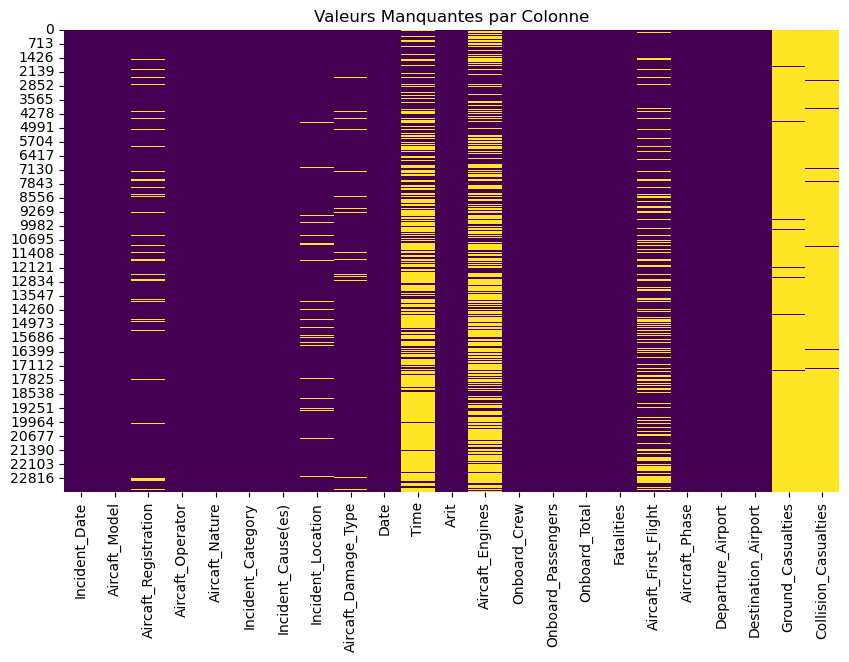

In [4]:
plt.figure(figsize=(10, 6))
sns.heatmap(original_data.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs Manquantes par Colonne")
plt.show()

We can see that ground casualties and collision casualties are mainly empty because it's very unlikely to happend in aircraft incident. Aircraft engines is also empty because due to degas it might not be easy to know wich engine is used. This lack of data leads us to focus on aircraft model that will provide good infos.
We will now reference this null value as unknown.


In [5]:
original_data['Ground_Casualties'] = original_data['Ground_Casualties'].fillna('Unknown')
original_data['Collision_Casualties'] = original_data['Collision_Casualties'].fillna('Unknown')
original_data['Aircaft_Engines'] = original_data['Aircaft_Engines'].fillna('Unknown')

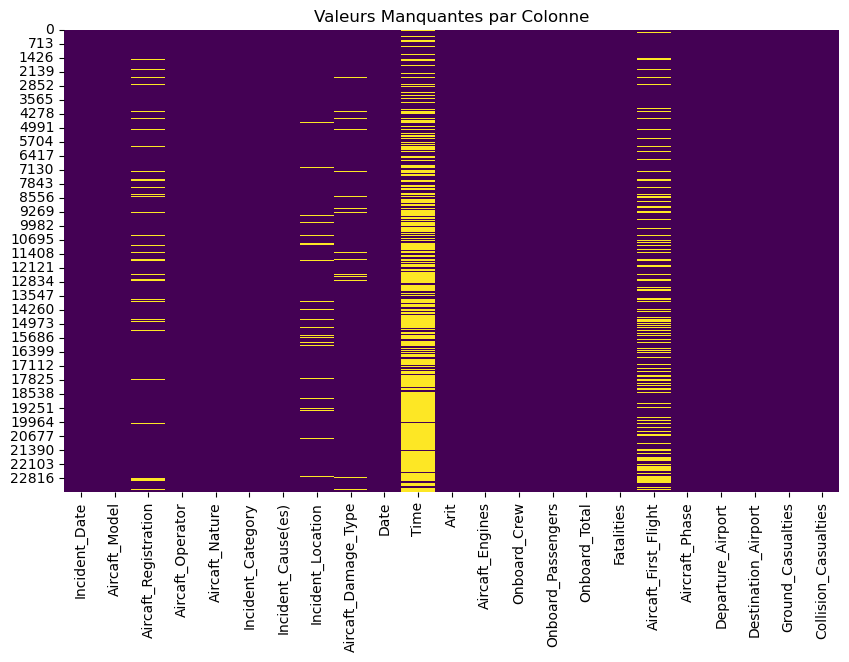

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(original_data.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs Manquantes par Colonne")
plt.show()

As we do for plane specifications, the time is not mendatory on our study, we just need the date which is always present, lets remove time column from our dataset, for the same reason we will remove aircraft first flight column.

In [7]:
fixed_data = original_data.drop(columns=['Time', 'Aircaft_First_Flight'])

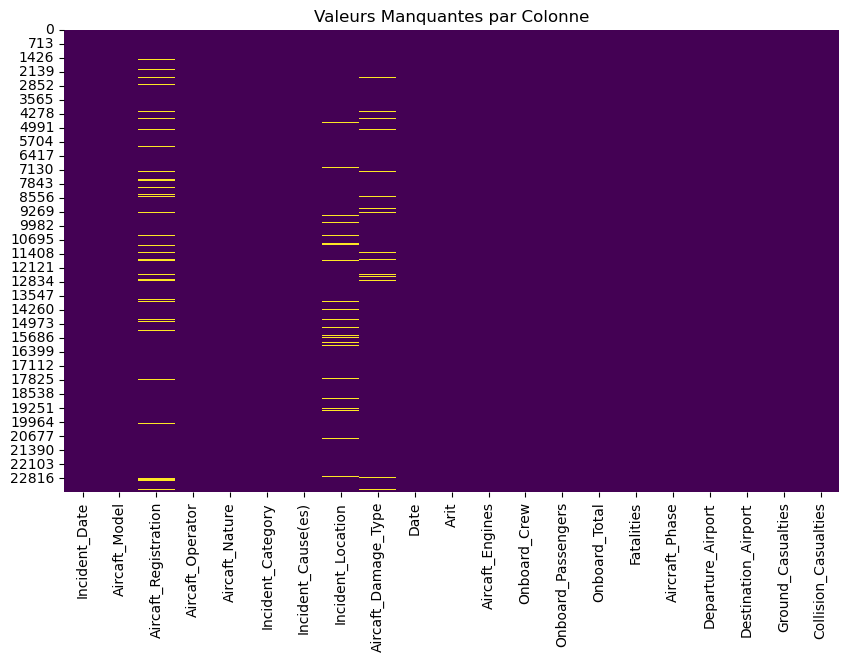

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(fixed_data.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs Manquantes par Colonne")
plt.show()

We will now procede to clean the last remaining missing value by labeling them as unknow again.


In [9]:
fixed_data['Aircaft_Registration'] = fixed_data['Aircaft_Registration'].fillna('Unknown')
fixed_data['Incident_Location'] = fixed_data['Incident_Location'].fillna('Unknown')
fixed_data['Aircaft_Damage_Type'] = fixed_data['Aircaft_Damage_Type'].fillna('Unknown')

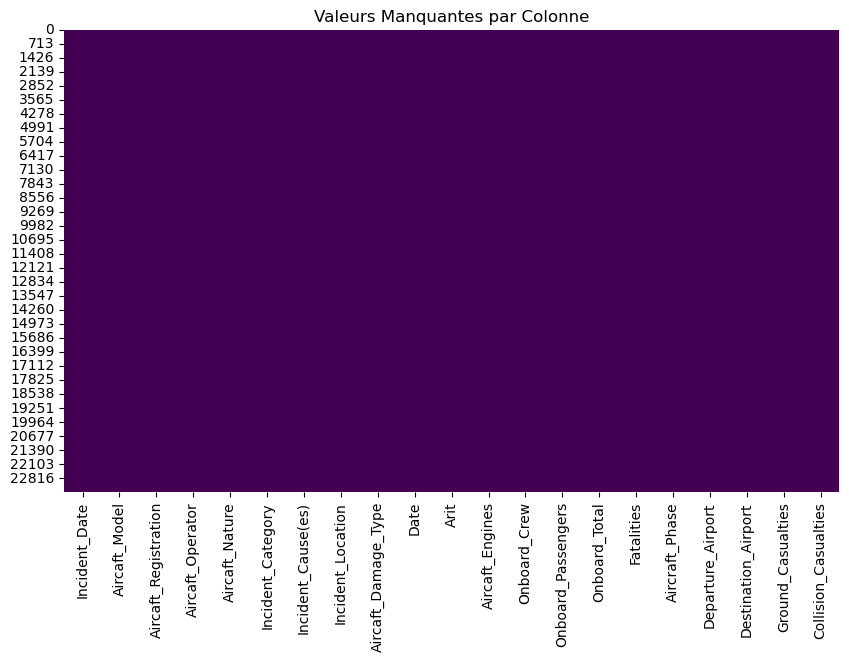

Incident_Date           0
Aircaft_Model           0
Aircaft_Registration    0
Aircaft_Operator        0
Aircaft_Nature          0
Incident_Category       0
Incident_Cause(es)      0
Incident_Location       0
Aircaft_Damage_Type     0
Date                    0
Arit                    0
Aircaft_Engines         0
Onboard_Crew            0
Onboard_Passengers      0
Onboard_Total           0
Fatalities              0
Aircraft_Phase          0
Departure_Airport       0
Destination_Airport     0
Ground_Casualties       0
Collision_Casualties    0
dtype: int64

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(fixed_data.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs Manquantes par Colonne")
plt.show()
fixed_data.isnull().sum()

Our dataset is now clean and empty of None values!



In [11]:
print(f"Unique values per columns :\n")
for i, col in enumerate(fixed_data):
    print(f"\t{i+1}. {col}': {fixed_data[col].unique()}\n")

Unique values per columns :

	1. Incident_Date': ['03-JAN-2022' '04-JAN-2022' '05-JAN-2022' ... '14-DEC-1920' '02-AUG-1919'
 '11-AUG-1919']

	2. Aircaft_Model': ['British Aerospace 4121 Jetstream 41'
 'British Aerospace 3101 Jetstream 31' 'Boeing 737-4H6' ...
 'Handley Page O/400' 'Caproni Ca.48' 'Felixstowe Fury']

	3. Aircaft_Registration': ['ZS-NRJ' 'HR-AYY' 'EP-CAP' ... 'G-EAKE' 'G-EAMA' 'N123']

	4. Aircaft_Operator': ['SA Airlink' 'LANHSA' 'Caspian Airlines' ... 'HP Indo-Burmese Transport'
 'Caproni' 'SNETA']

	5. Aircaft_Nature': ['Domestic Non Scheduled Passenger' 'Domestic Scheduled Passenger' 'Cargo'
 'Illegal Flight' 'Military' 'Unknown' 'Passenger' 'Ambulance' 'Test'
 'Training' '-' 'Agricultural' 'Ferry/positioning' 'Private' 'Executive'
 'Parachuting' 'Fire fighting' 'Aerial Work (Calibration, Photo)'
 'International Scheduled Passenger' 'Survey/research'
 "Int'l Non Scheduled Passenger" 'Official state flight' 'Demonstration'
 'Non Scheduled Passenger' 'Scheduled Passeng

# Data analysis
***

Now, let’s analyze the cleaned dataset. First, we’ll examine the distribution of the different columns.

In [12]:
# Filter data after 2000 using string extraction
fixed_data = fixed_data[fixed_data['Date'].str.extract(r'(\d{4})')[0].astype(int) >= 2000]

# Define column types and exclude unwanted columns
numeric_columns = fixed_data.select_dtypes(include=['number']).columns
categorical_columns = fixed_data.select_dtypes(exclude=['number']).columns
# Remove irrelevant columns
columns_to_drop = ['Date', 'Departure_Airport', 'Destination_Airport', 'Incident_Date']
categorical_columns = categorical_columns.drop([col for col in columns_to_drop if col in categorical_columns])

# Define color scheme
colors = px.colors.qualitative.Set3

# For numeric columns with special handling for Fatalities
for i, col in enumerate(numeric_columns):
    data = fixed_data[fixed_data[col] != 'Unknown']
    if data[col].nunique() > 1:
        if col == 'Fatalities':
            # Create two separate visualizations for Fatalities
            
            # 1. Pie chart for zero vs non-zero
            fatality_summary = pd.Series({
                'No Fatalities': len(data[data[col] == 0]),
                'With Fatalities': len(data[data[col] > 0])
            })
            
            fig = px.pie(
                values=fatality_summary.values,
                names=fatality_summary.index,
                title='Distribution of Incidents by Fatality Occurrence',
                color_discrete_sequence=[colors[0], colors[1]]
            )
            fig.update_layout(
                title_x=0.5,
                template='plotly_white',
                height=500
            )
            fig.show()
            
            # 2. Distribution of non-zero fatalities on log scale
            non_zero_data = data[data[col] > 0]
            if len(non_zero_data) > 0:
                fig = px.histogram(
                    non_zero_data,
                    x=col,
                    nbins=min(30, len(non_zero_data)),
                    title='Distribution of Non-Zero Fatalities (Log Scale)',
                    log_y=True,  # Use log scale for better visualization
                    color_discrete_sequence=[colors[2]]
                )
                fig.update_layout(
                    title_x=0.5,
                    template='plotly_white',
                    showlegend=False,
                    height=500
                )
                fig.show()
                
                # Print summary statistics
                print("\nFatalities Summary:")
                print(f"No fatalities: {len(data[data[col] == 0])} ({len(data[data[col] == 0])/len(data)*100:.1f}%)")
                print(f"With fatalities: {len(non_zero_data)} ({len(non_zero_data)/len(data)*100:.1f}%)")
                print(f"Average fatalities when present: {non_zero_data[col].mean():.1f}")
                print(f"Median fatalities when present: {non_zero_data[col].median():.1f}")
        else:
            # Normal histogram for other numeric columns
            fig = px.histogram(
                data,
                x=col,
                nbins=min(30, data[col].nunique()),
                title=f'Distribution of {col}',
                color_discrete_sequence=[colors[i % len(colors)]]
            )
            fig.update_layout(
                title_x=0.5,
                template='plotly_white',
                showlegend=False,
                height=500
            )
            fig.show()

# For categorical columns with improved filtering
for i, col in enumerate(categorical_columns):
    # Filter out Unknown and Info-Unavailable
    data = fixed_data[~fixed_data[col].isin(['Unknown', 'Info-Unavailable'])]
    if len(data) < len(fixed_data) * 0.1:  # Skip if >90% unknown
        continue
    
    value_counts = data[col].value_counts()
    n_unique = len(value_counts)
    
    if n_unique <= 5:  # Pie chart for few categories
        fig = px.pie(
            values=value_counts.values,
            names=value_counts.index,
            title=f'Distribution of {col}',
            color_discrete_sequence=colors
        )
    elif n_unique <= 10:  # Horizontal bar for medium categories
        fig = px.bar(
            x=value_counts.values,
            y=value_counts.index,
            orientation='h',
            title=f'Distribution of {col}',
            color_discrete_sequence=[colors[i % len(colors)]]
        )
    else:  # Top 10 vertical bar for many categories
        top_10 = value_counts.nlargest(10)
        fig = px.bar(
            x=top_10.index,
            y=top_10.values,
            title=f'Top 10 Most Common Values in {col}',
            color_discrete_sequence=[colors[i % len(colors)]]
        )
    
    fig.update_layout(
        title_x=0.5,
        template='plotly_white',
        height=500,
        showlegend=(n_unique <= 5)
    )
    
    if n_unique > 10:
        fig.update_layout(xaxis_tickangle=45)
    
    fig.show()


Fatalities Summary:
No fatalities: 3353 (73.1%)
With fatalities: 1235 (26.9%)
Average fatalities when present: 17.6
Median fatalities when present: 4.0


Now, let’s examine the correlation between the different columns in our dataset to identify which ones are correlated with our target variable, Plane model
.

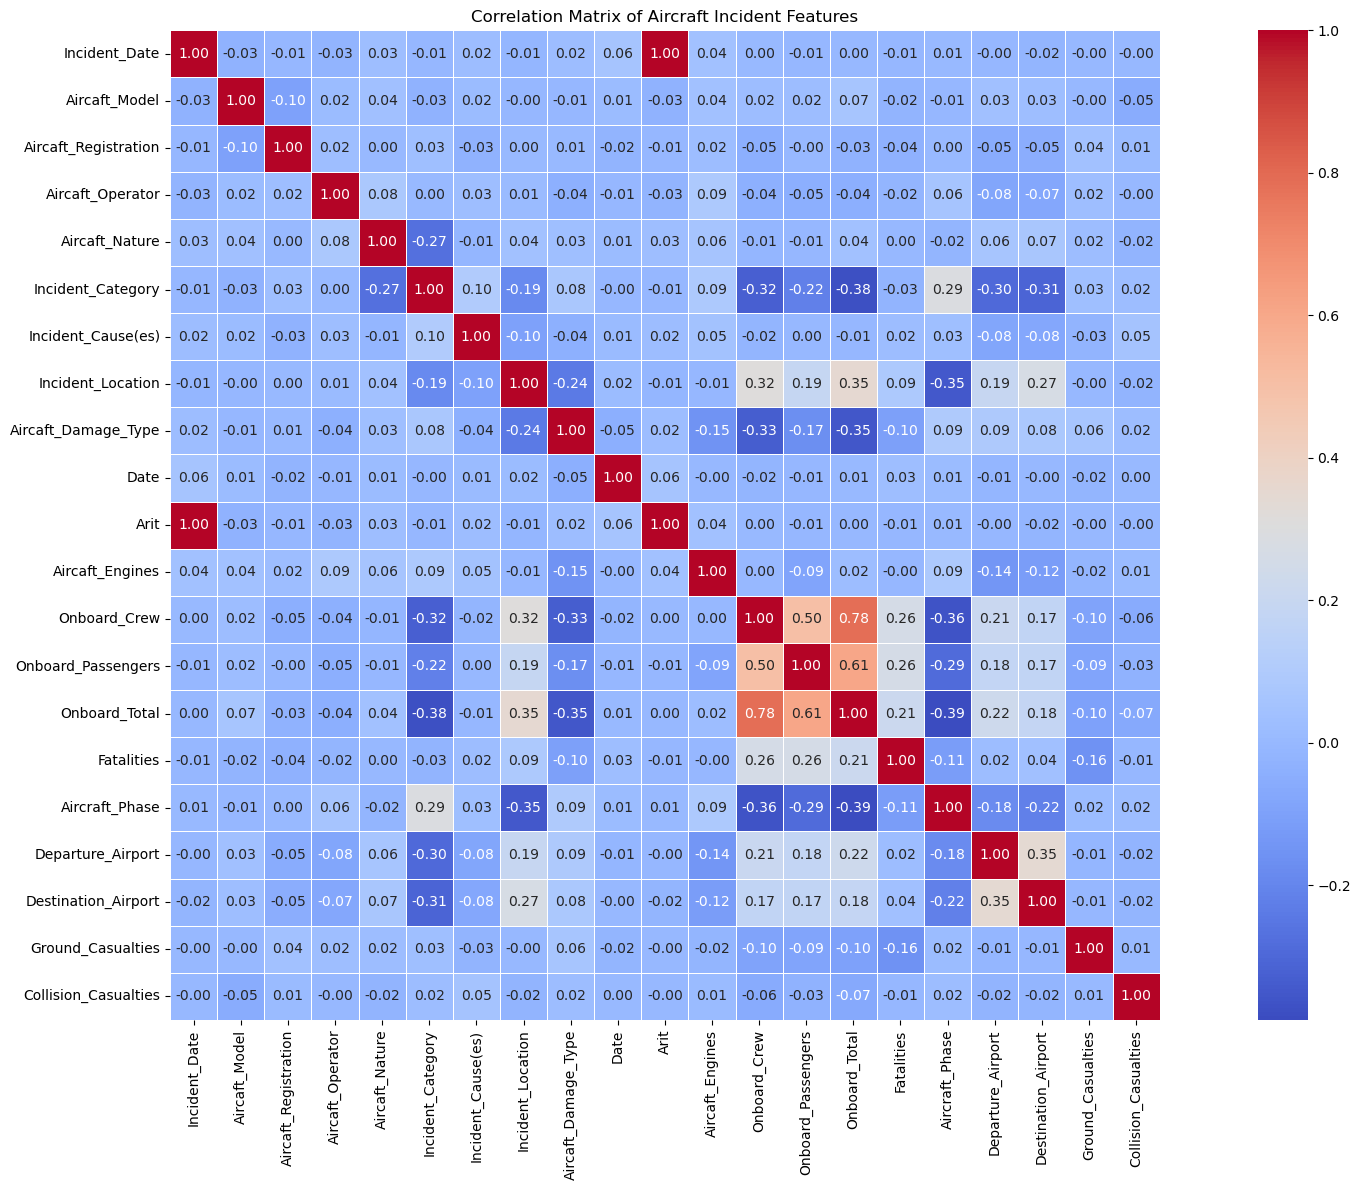

In [13]:
# First, handle any categorical data that can be mapped to numeric values
# For example, if you have any time/duration related fields:
time_map = {
    # Add your mappings here similar to their sleep duration mapping
    # Example: '1-2 hours': 1.5, '2-3 hours': 2.5, etc.
}

def clean_time_data(value):
    if value in time_map:
        return time_map[value]
    return None

# Apply numeric mapping to any categorical columns that can be numerically represented
# Example: fixed_data['Duration'] = fixed_data['Duration'].apply(clean_time_data)

# Then encode remaining categorical features
categorical_features = fixed_data.select_dtypes(exclude=[np.number]).columns
encode = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
fixed_data[categorical_features] = encode.fit_transform(fixed_data[categorical_features]).astype(int)

# Create correlation matrix for numeric columns
correlation_matrix = fixed_data.select_dtypes(include=['number']).corr()

# Create figure with specific size - increased height from 8 to 12
plt.figure(figsize=(20, 12))

# Create heatmap with specific styling
sns.heatmap(
    correlation_matrix,
    annot=True,         # Show numbers
    cmap='coolwarm',    # Use red-blue colormap
    fmt='.2f',          # Format numbers to 2 decimal places
    square=True,        # Make cells square
    linewidths=0.5,     # Add lines between cells
    annot_kws={'size': 10}  # Increase annotation font size
)

# Customize the layout
plt.title('Correlation Matrix of Aircraft Incident Features')
plt.tight_layout()
plt.show()

Based on the correlation matrix, predicting aircraft incidents solely from the aircraft model would be challenging due to very weak correlations with incident-related variables (most correlations < ±0.10), suggesting we need to consider multiple features and their interactions for effective prediction.

Given the weak correlations between aircraft model and incident variables, we should implement a multivariate machine learning approach using ensemble methods (like XGBoost or Random Forest) that can capture complex feature interactions while incorporating key variables like Aircraft_Nature and Incident_Category alongside the aircraft model.

# Models and Evaluation
***
We will create a machine learning pipeline that automates data preprocessing, applies SMOTE for balancing, and uses GridSearchCV for hyperparameter tuning to build a model that can effectively predict aircraft incidents based on multiple features, since the aircraft model alone shows insufficient correlation with incident outcomes.

In [14]:
# First, analyze and filter the data more strictly
print("Analyzing Aircraft Model distribution...")
value_counts = fixed_data['Aircaft_Model'].value_counts()
print(f"Original number of classes: {len(value_counts)}")

# Increase minimum instances to ensure enough samples for SMOTE
min_instances = 5  # Increased from 3 to 5
frequent_models = value_counts[value_counts >= min_instances].index
filtered_data = fixed_data[fixed_data['Aircaft_Model'].isin(frequent_models)]

print("\nAfter filtering:")
print(f"Number of remaining classes: {len(filtered_data['Aircaft_Model'].unique())}")
print(f"Total remaining samples: {len(filtered_data)}")

def aircraft_incident_pipeline(scalers, models, X, y, param_finetunings=None, test_size=0.2):
    results = []
    if param_finetunings is None:
        param_finetunings = [{} for _ in models]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Calculate minimum samples in minority class
    min_samples = y_train.value_counts().min()
    k_neighbors = min(min_samples - 1, 3)  # Ensure k_neighbors is valid
    
    for scaler in scalers:
        for model, param_finetuning in zip(models, param_finetunings):
            print(f"\nTesting {scaler.__class__.__name__} with {model.__class__.__name__}")
            
            try:
                # Create pipeline with modified SMOTE parameters
                pipeline = ImbPipeline([
                    ('scaler', scaler),
                    ('smote', SMOTE(
                        random_state=42,
                        k_neighbors=k_neighbors,
                        sampling_strategy='auto'
                    )),
                    ('incident_model', model)
                ])

                # Hyperparameter optimization
                if param_finetuning:
                    grid_search = GridSearchCV(
                        pipeline,
                        param_finetuning,
                        cv=5,
                        scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'],
                        refit='roc_auc_ovr',
                        n_jobs=-1,
                        verbose=1
                    )
                    grid_search.fit(X_train, y_train)
                    pipeline = grid_search.best_estimator_
                    best_params = grid_search.best_params_
                else:
                    pipeline.fit(X_train, y_train)
                    best_params = pipeline.named_steps['incident_model'].get_params()

                # Generate predictions
                y_pred = pipeline.predict(X_test)
                y_pred_proba = pipeline.predict_proba(X_test)

                # Calculate metrics
                results.append({
                    'scaler': scaler.__class__.__name__,
                    'model': model.__class__.__name__,
                    'best_params': best_params,
                    'accuracy': accuracy_score(y_test, y_pred),
                    'f1_score': f1_score(y_test, y_pred, average='macro'),
                    'roc_auc': roc_auc_score(y_test, y_pred_proba, multi_class='ovr'),
                    'classification_report': classification_report(y_test, y_pred),
                    'confusion_matrix': confusion_matrix(y_test, y_pred)
                })
            except Exception as e:
                print(f"Error with {scaler.__class__.__name__} and {model.__class__.__name__}: {str(e)}")
                continue
    
    return pd.DataFrame(results)

# Rest of the code remains the same

Analyzing Aircraft Model distribution...
Original number of classes: 1308

After filtering:
Number of remaining classes: 208
Total remaining samples: 2929


In [15]:
# Define scalers and models
scalers = [StandardScaler(), MinMaxScaler()]

models = [
    RandomForestClassifier(random_state=42),
    XGBClassifier(eval_metric='mlogloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42)
]

# Define parameter grids for each model
param_grids = [
    {
        'incident_model__n_estimators': [100, 200],
        'incident_model__max_depth': [10, 20, 30]
    },
    {
        'incident_model__n_estimators': [100, 200],
        'incident_model__max_depth': [6, 8, 10],
        'incident_model__learning_rate': [0.01, 0.1]
    },
    {
        'incident_model__iterations': [100, 200],
        'incident_model__depth': [6, 8],
        'incident_model__learning_rate': [0.01, 0.1]
    }
]

# Prepare features and target
X = filtered_data.drop(['Aircaft_Model', 'Date', 'Departure_Airport', 'Destination_Airport', 'Incident_Date'], axis=1)

y = filtered_data['Aircaft_Model']

# Run pipeline and display results (robustified)
try:
    results = aircraft_incident_pipeline(scalers, models, X, y, param_grids)
except Exception as e:
    print("Pipeline execution failed:", str(e))
    results = pd.DataFrame()

print("\nModel Performance Results:")
if not isinstance(results, pd.DataFrame) or results.empty:
    print("No results produced. Check earlier cells for error messages printed during pipeline runs.")
    # If there were any exceptions caught inside aircraft_incident_pipeline they should have been printed.
else:
    # Ensure expected columns exist before selecting
    expected_cols = ['scaler', 'model', 'accuracy', 'f1_score', 'roc_auc']
    missing = [c for c in expected_cols if c not in results.columns]
    if missing:
        print(f"Results DataFrame is missing expected columns: {missing}")
        print("Available columns:", results.columns.tolist())
        display(results)
    else:
        display(results[expected_cols])

        # Show best performing model (by roc_auc if available)
        try:
            best_idx = results['roc_auc'].astype(float).idxmax()
            best_model = results.loc[best_idx]
            print("\nBest Performing Model:")
            print(f"Scaler: {best_model['scaler']}")
            print(f"Model: {best_model['model']}")
            print(f"ROC-AUC Score: {float(best_model['roc_auc']):.4f}")
            print(f"F1 Score: {float(best_model['f1_score']):.4f}")
            print(f"Accuracy: {float(best_model['accuracy']):.4f}")

            print("\nClassification Report:")
            print(best_model.get('classification_report', 'No classification report available'))
        except Exception as e:
            print("Could not determine best model:", e)
            display(results)



Testing StandardScaler with RandomForestClassifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Error with StandardScaler and RandomForestClassifier: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipel

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Error with StandardScaler and XGBClassifier: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipeline.py", 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Error with StandardScaler and CatBoostClassifier: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipeline.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Error with MinMaxScaler and RandomForestClassifier: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipelin

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Error with MinMaxScaler and XGBClassifier: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipeline.py", li

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Error with MinMaxScaler and CatBoostClassifier: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\imblearn\pipeline.py

## Choice of model
***
We then tested all models with various scalers, without applying any fine-tuning, to identify the best-performing ones to retain for further fine-tuning.

In [16]:
# GridSearch evaluation with multiple models on Aircraft dataset

# Force reload notebook_utils module to ensure latest changes are loaded
import sys
import importlib

# Remove cached module if present
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']
    print('Cleared cached notebook_utils module')

# Now import my_pipeline_gridsearch from notebook_utils
try:
    from notebook_utils import my_pipeline_gridsearch
    print('Successfully imported my_pipeline_gridsearch from notebook_utils')
except ImportError as e:
    print(f'ImportError: {e}')
    print('Checking available functions in notebook_utils...')
    import notebook_utils as nu
    print('Available functions:', [attr for attr in dir(nu) if not attr.startswith('_')])
    raise

# Prepare data - use filtered_data if available, otherwise load CSV
try:
    data = filtered_data.copy()
    print(f'Using filtered_data: {data.shape}')
except NameError:
    print('filtered_data not found, loading from CSV...')
    data = pd.read_csv(r'Aircraft_Incident_Dataset.csv')
    data.columns = [c.strip() for c in data.columns]

# Auto-detect model and damage columns (target variable)
model_col = next((c for c in data.columns if 'model' in c.lower()), None)
damage_col = next((c for c in data.columns if 'damage' in c.lower()), None)

if model_col is None or damage_col is None:
    raise RuntimeError(f"Could not find model or damage columns. Available: {data.columns.tolist()}")

print(f"Found model column: {model_col}")
print(f"Found damage column: {damage_col}")

# Prepare X and y
X = data.drop(columns=[damage_col, 'Date', 'Departure_Airport', 'Destination_Airport', 'Incident_Date'], errors='ignore')
y = data[damage_col]

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Target classes: {y.nunique()}")
print(f"Features: {X.shape[1]}")

# Define scalers
scalers = [MinMaxScaler(), StandardScaler()]

# Define models (comprehensive ensemble)
models = [
    LogisticRegression(max_iter=5000),
    GaussianNB(),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    AdaBoostClassifier(algorithm='SAMME', random_state=42),
    XGBClassifier(eval_metric='mlogloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    GradientBoostingClassifier(random_state=42),
    MLPClassifier(max_iter=2000, random_state=42),
]

# Run GridSearch pipeline
print("\nRunning GridSearch evaluation on all models...")
results_normal = my_pipeline_gridsearch(scalers, models, X, y)

# Sort by ROC-AUC and display results
results_normal = results_normal.sort_values(by='roc_auc', ascending=False)
print("\n=== Model Evaluation Results ===")
display(results_normal[['scaler', 'model', 'roc_auc', 'accuracy', 'f1_score']])

# Show top 3 models
print("\n=== Top 3 Best Models ===")
for idx, (i, row) in enumerate(results_normal.head(3).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")

Successfully imported my_pipeline_gridsearch from notebook_utils
Using filtered_data: (2929, 21)
Found model column: Aircaft_Model
Found damage column: Aircaft_Damage_Type
Dataset shape: X=(2929, 16), y=(2929,)
Target classes: 6
Features: 16

Running GridSearch evaluation on all models...

Testing scaler: MinMaxScaler, model: LogisticRegression

Testing scaler: MinMaxScaler, model: GaussianNB

Testing scaler: MinMaxScaler, model: GaussianNB

Testing scaler: MinMaxScaler, model: RandomForestClassifier

Testing scaler: MinMaxScaler, model: RandomForestClassifier

Testing scaler: MinMaxScaler, model: AdaBoostClassifier

Testing scaler: MinMaxScaler, model: AdaBoostClassifier

Testing scaler: MinMaxScaler, model: XGBClassifier

Testing scaler: MinMaxScaler, model: XGBClassifier

Testing scaler: MinMaxScaler, model: CatBoostClassifier

Testing scaler: MinMaxScaler, model: CatBoostClassifier


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().




Testing scaler: MinMaxScaler, model: GradientBoostingClassifier

Testing scaler: MinMaxScaler, model: MLPClassifier

Testing scaler: MinMaxScaler, model: MLPClassifier

Testing scaler: StandardScaler, model: LogisticRegression

Testing scaler: StandardScaler, model: LogisticRegression

Testing scaler: StandardScaler, model: GaussianNB

Testing scaler: StandardScaler, model: GaussianNB

Testing scaler: StandardScaler, model: RandomForestClassifier

Testing scaler: StandardScaler, model: RandomForestClassifier

Testing scaler: StandardScaler, model: AdaBoostClassifier

Testing scaler: StandardScaler, model: AdaBoostClassifier

Testing scaler: StandardScaler, model: XGBClassifier

Testing scaler: StandardScaler, model: XGBClassifier

Testing scaler: StandardScaler, model: CatBoostClassifier

Testing scaler: StandardScaler, model: CatBoostClassifier


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().




Testing scaler: StandardScaler, model: GradientBoostingClassifier

Testing scaler: StandardScaler, model: MLPClassifier

Testing scaler: StandardScaler, model: MLPClassifier

=== Model Evaluation Results ===

=== Model Evaluation Results ===


,scaler,model,roc_auc,accuracy,f1_score
6,MinMaxScaler,GradientBoostingClassifier,0.880285,0.650171,0.575346
4,MinMaxScaler,XGBClassifier,0.878790,0.634812,0.518999
14,StandardScaler,GradientBoostingClassifier,0.875178,0.641638,0.573044
2,MinMaxScaler,RandomForestClassifier,0.873871,0.646758,0.588765
12,StandardScaler,XGBClassifier,0.873026,0.617747,0.516497
5,MinMaxScaler,CatBoostClassifier,0.870476,0.653584,0.586338
13,StandardScaler,CatBoostClassifier,0.865000,0.619454,0.534392
10,StandardScaler,RandomForestClassifier,0.863740,0.631399,0.557972
11,StandardScaler,AdaBoostClassifier,0.792665,0.368601,0.327361
3,MinMaxScaler,AdaBoostClassifier,0.792032,0.455631,0.366825



=== Top 3 Best Models ===

1. GradientBoostingClassifier with MinMaxScaler
   ROC-AUC: 0.8803
   Accuracy: 0.6502
   F1-Score: 0.5753

2. XGBClassifier with MinMaxScaler
   ROC-AUC: 0.8788
   Accuracy: 0.6348
   F1-Score: 0.5190

3. GradientBoostingClassifier with StandardScaler
   ROC-AUC: 0.8752
   Accuracy: 0.6416
   F1-Score: 0.5730


## Choice of scaler
***
Now, we fine-tuned our three models using the Optuna library, which outperforms GridSearch in exploring a wider range of parameter possibilities. The objective at this stage is to identify the best normalization process, ensuring that only the final fine-tuning remains to be completed.

In [24]:
def my_pipeline_optuna(scalers, models, X, y, param_spaces=None, batch_test_size=0.2, n_trials=10):
    results = []

    # Default param spaces
    if param_spaces is None:
        param_spaces = [{} for _ in models]

    # Train / Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=batch_test_size,
        random_state=42,
        stratify=y  # essentiel en multiclass
    )

    # Loop
    for scaler in scalers:
        for model, param_space in zip(models, param_spaces):

            print(f"\nTesting scaler: {scaler.__class__.__name__}, model: {model.__class__.__name__}")

            # ---- OPTUNA OBJECTIVE ----
            def objective(trial):

                # Select hyperparams
                params = {}
                for key, values in param_space.items():
                    if isinstance(values, list):
                        params[key] = trial.suggest_categorical(key, values)
                    elif isinstance(values, tuple) and all(isinstance(v, float) for v in values):
                        params[key] = trial.suggest_float(key, *values)
                    elif isinstance(values, tuple) and all(isinstance(v, int) for v, in enumerate(values)):
                        params[key] = trial.suggest_int(key, *values)
                    else:
                        raise ValueError(f"Invalid parameter specification for {key}: {values}")

                # Build model
                current_model = model.__class__(**params)

                # Build pipeline (scale → SMOTE → model)
                pipeline = ImbPipeline(steps=[
                    ('scale', scaler),
                    ('smote', SMOTE(random_state=42)),
                    ('model', current_model)
                ])

                # CV score with multiclass ROC AUC
                scores = cross_val_score(
                    pipeline, X_train, y_train,
                    cv=5,
                    scoring='roc_auc_ovr',
                    n_jobs=-1
                )
                return scores.mean()

            # ---- OPTUNA OPTIMISATION ----
            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=n_trials, n_jobs=-1)

            best_params = study.best_params

            # ---- TRAIN FINAL PIPELINE ----
            final_model = model.__class__(**best_params)

            pipeline = ImbPipeline(steps=[
                ('scale', scaler),
                ('smote', SMOTE(random_state=42)),
                ('model', final_model)
            ])
            pipeline.fit(X_train, y_train)

            # ---- PREDICTIONS ----
            y_pred = pipeline.predict(X_test)

            # roc auc if available
            if hasattr(pipeline, "predict_proba"):
                y_proba = pipeline.predict_proba(X_test)
                roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
            else:
                roc_auc = None

            # ---- METRICS ----
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            report = classification_report(y_test, y_pred)
            confusion = confusion_matrix(y_test, y_pred)

            # ---- SAVE RESULTS ----
            results.append({
                'scaler': scaler.__class__.__name__,
                'model': model.__class__.__name__,
                'best_params': best_params,
                'accuracy': accuracy,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'classification_report': report,
                'confusion_matrix': confusion
            })

    return pd.DataFrame(results)


In [25]:
# Fine-tuning: Predict Aircaft_Damage_Type based on Aircaft_Model

# Force reload notebook_utils
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']

from notebook_utils import my_pipeline_optuna

# Prepare data - use filtered_data
try:
    data = filtered_data.copy()
    print(f"Using filtered_data: {data.shape}")
except NameError:
    print("filtered_data not found, loading from CSV...")
    data = pd.read_csv(r'Aircraft_Incident_Dataset.csv')
    data.columns = [c.strip() for c in data.columns]

print(f"Total samples: {len(data)}")
print(f"Aircaft_Model unique values: {data['Aircaft_Model'].nunique()}")
print(f"Aircaft_Damage_Type unique values: {data['Aircaft_Damage_Type'].nunique()}")

# Prepare features (X) and target (y)
# We use Aircaft_Model as primary feature, but can add other features
X = data[['Aircaft_Model']].copy()
y = data['Aircaft_Damage_Type'].copy()

print(f"\nDataset: X={X.shape}, y={y.shape}")
print(f"Target classes: {y.nunique()}")

# Define scalers and fine-tuned models
scalers = [MinMaxScaler(), StandardScaler()]

models = [
    XGBClassifier(eval_metric='logloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    GradientBoostingClassifier(random_state=42),
]

# Fine-tuned parameter spaces (tuples = ranges, lists = categorical)
param_finetunings = [
    {  # XGBoost
        'n_estimators': (250, 300),
        'max_depth': (8, 12),
        'learning_rate': (0.01, 0.07),
        'subsample': (0.8, 1.0),
        'colsample_bytree': (0.8, 1.0)
    },
    {  # CatBoost
        'iterations': (350, 500),
        'depth': (5, 9),
        'learning_rate': (0.18, 0.26)
    },
    {  # Gradient Boosting
        'n_estimators': (80, 130),
        'learning_rate': (0.2, 0.3),
        'max_depth': (3, 7)
    },
]

# Run Optuna fine-tuning
print("\nRunning advanced Optuna fine-tuning for Damage Type prediction...\n")
results_finetuned = my_pipeline_optuna(scalers, models, X, y, param_finetunings, n_trials=50)

# Display results sorted by ROC-AUC
results_finetuned = results_finetuned.sort_values(by='roc_auc', ascending=False)
print("\n=== Fine-Tuned Results: Aircaft_Damage_Type Prediction ===")
display(results_finetuned[['scaler', 'model', 'roc_auc', 'accuracy', 'f1_score']])

# Show top 3 best combinations
print("\n=== Top 3 Best Model-Scaler Combinations ===")
for idx, (i, row) in enumerate(results_finetuned.head(3).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")
    print(f"   Best params: {row['best_params']}")

[I 2025-12-05 22:41:27,745] A new study created in memory with name: no-name-151faeef-9d33-4afc-9970-d3aa21d5a513


Using filtered_data: (2929, 21)
Total samples: 2929
Aircaft_Model unique values: 208
Aircaft_Damage_Type unique values: 6

Dataset: X=(2929, 1), y=(2929,)
Target classes: 6

Running advanced Optuna fine-tuning for Damage Type prediction...


Testing scaler: MinMaxScaler, model: XGBClassifier


[I 2025-12-05 22:41:32,606] Trial 0 finished with value: 0.1990396987217622 and parameters: {'n_estimators': 269, 'max_depth': 12, 'learning_rate': 0.05391963650868431, 'subsample': 0.9197316968394074, 'colsample_bytree': 0.8312037280884873}. Best is trial 0 with value: 0.1990396987217622.
[I 2025-12-05 22:41:35,929] Trial 1 finished with value: 0.19817693837771516 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.06197056874649612, 'subsample': 0.9202230023486417, 'colsample_bytree': 0.941614515559209}. Best is trial 0 with value: 0.1990396987217622.
[I 2025-12-05 22:41:35,929] Trial 1 finished with value: 0.19817693837771516 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.06197056874649612, 'subsample': 0.9202230023486417, 'colsample_bytree': 0.941614515559209}. Best is trial 0 with value: 0.1990396987217622.
[I 2025-12-05 22:41:39,833] Trial 2 finished with value: 0.19734080688725492 and parameters: {'n_estimators': 251, 'max_depth': 1


Testing scaler: MinMaxScaler, model: CatBoostClassifier


[I 2025-12-05 22:43:29,235] Trial 0 finished with value: 0.20776915005179566 and parameters: {'iterations': 406, 'depth': 9, 'learning_rate': 0.2385595153449124}. Best is trial 0 with value: 0.20776915005179566.
[I 2025-12-05 22:43:33,222] Trial 1 finished with value: 0.20508312540648577 and parameters: {'iterations': 440, 'depth': 5, 'learning_rate': 0.1924795616268962}. Best is trial 0 with value: 0.20776915005179566.
[I 2025-12-05 22:43:33,222] Trial 1 finished with value: 0.20508312540648577 and parameters: {'iterations': 440, 'depth': 5, 'learning_rate': 0.1924795616268962}. Best is trial 0 with value: 0.20776915005179566.
[I 2025-12-05 22:43:49,159] Trial 2 finished with value: 0.20638076099038125 and parameters: {'iterations': 358, 'depth': 9, 'learning_rate': 0.2280892009394567}. Best is trial 0 with value: 0.20776915005179566.
[I 2025-12-05 22:43:49,159] Trial 2 finished with value: 0.20638076099038125 and parameters: {'iterations': 358, 'depth': 9, 'learning_rate': 0.22808920

0:	learn: 1.7079690	total: 28.3ms	remaining: 13.5s
1:	learn: 1.6468378	total: 55ms	remaining: 13.1s
2:	learn: 1.6033749	total: 80.3ms	remaining: 12.7s
3:	learn: 1.5713812	total: 106ms	remaining: 12.6s
4:	learn: 1.5439398	total: 132ms	remaining: 12.5s
5:	learn: 1.5252559	total: 158ms	remaining: 12.5s
6:	learn: 1.5075633	total: 186ms	remaining: 12.6s
7:	learn: 1.4957603	total: 212ms	remaining: 12.5s
8:	learn: 1.4855377	total: 239ms	remaining: 12.5s
9:	learn: 1.4745510	total: 265ms	remaining: 12.4s
10:	learn: 1.4636744	total: 293ms	remaining: 12.5s
11:	learn: 1.4570548	total: 303ms	remaining: 11.8s
12:	learn: 1.4510288	total: 330ms	remaining: 11.8s
13:	learn: 1.4432493	total: 356ms	remaining: 11.8s
14:	learn: 1.4367757	total: 383ms	remaining: 11.8s
15:	learn: 1.4296926	total: 409ms	remaining: 11.8s
16:	learn: 1.4163397	total: 435ms	remaining: 11.8s
17:	learn: 1.4096038	total: 461ms	remaining: 11.8s
9:	learn: 1.4745510	total: 265ms	remaining: 12.4s
10:	learn: 1.4636744	total: 293ms	remaini

[I 2025-12-05 22:52:57,991] A new study created in memory with name: no-name-6ffcae2c-ed25-4713-bd9f-c0788d5e6df3


475:	learn: 1.0746814	total: 12.7s	remaining: 80.2ms
476:	learn: 1.0745747	total: 12.8s	remaining: 53.5ms
477:	learn: 1.0745230	total: 12.8s	remaining: 26.7ms
478:	learn: 1.0743322	total: 12.8s	remaining: 0us

Testing scaler: MinMaxScaler, model: GradientBoostingClassifier


[I 2025-12-05 22:53:02,048] Trial 0 finished with value: 0.2514653095130308 and parameters: {'n_estimators': 99, 'learning_rate': 0.2950714306409916, 'max_depth': 6}. Best is trial 0 with value: 0.2514653095130308.
[I 2025-12-05 22:53:04,286] Trial 1 finished with value: 0.22125758072223628 and parameters: {'n_estimators': 110, 'learning_rate': 0.21560186404424367, 'max_depth': 3}. Best is trial 0 with value: 0.2514653095130308.
[I 2025-12-05 22:53:04,286] Trial 1 finished with value: 0.22125758072223628 and parameters: {'n_estimators': 110, 'learning_rate': 0.21560186404424367, 'max_depth': 3}. Best is trial 0 with value: 0.2514653095130308.
[I 2025-12-05 22:53:07,626] Trial 2 finished with value: 0.2480224828448676 and parameters: {'n_estimators': 82, 'learning_rate': 0.2866176145774935, 'max_depth': 6}. Best is trial 0 with value: 0.2514653095130308.
[I 2025-12-05 22:53:07,626] Trial 2 finished with value: 0.2480224828448676 and parameters: {'n_estimators': 82, 'learning_rate': 0.28


Testing scaler: StandardScaler, model: XGBClassifier


[I 2025-12-05 22:56:13,792] Trial 0 finished with value: 0.1974888079418105 and parameters: {'n_estimators': 269, 'max_depth': 12, 'learning_rate': 0.05391963650868431, 'subsample': 0.9197316968394074, 'colsample_bytree': 0.8312037280884873}. Best is trial 0 with value: 0.1974888079418105.
[I 2025-12-05 22:56:15,424] Trial 1 finished with value: 0.19607865741011593 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.06197056874649612, 'subsample': 0.9202230023486417, 'colsample_bytree': 0.941614515559209}. Best is trial 0 with value: 0.1974888079418105.
[I 2025-12-05 22:56:15,424] Trial 1 finished with value: 0.19607865741011593 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.06197056874649612, 'subsample': 0.9202230023486417, 'colsample_bytree': 0.941614515559209}. Best is trial 0 with value: 0.1974888079418105.
[I 2025-12-05 22:56:17,518] Trial 2 finished with value: 0.1955211107064396 and parameters: {'n_estimators': 251, 'max_depth': 12


Testing scaler: StandardScaler, model: CatBoostClassifier


[I 2025-12-05 22:58:07,330] Trial 0 finished with value: 0.20560660718691698 and parameters: {'iterations': 406, 'depth': 9, 'learning_rate': 0.2385595153449124}. Best is trial 0 with value: 0.20560660718691698.
[I 2025-12-05 22:58:10,383] Trial 1 finished with value: 0.20234893545847682 and parameters: {'iterations': 440, 'depth': 5, 'learning_rate': 0.1924795616268962}. Best is trial 0 with value: 0.20560660718691698.
[I 2025-12-05 22:58:10,383] Trial 1 finished with value: 0.20234893545847682 and parameters: {'iterations': 440, 'depth': 5, 'learning_rate': 0.1924795616268962}. Best is trial 0 with value: 0.20560660718691698.
[I 2025-12-05 22:58:25,010] Trial 2 finished with value: 0.20767808033076332 and parameters: {'iterations': 358, 'depth': 9, 'learning_rate': 0.2280892009394567}. Best is trial 2 with value: 0.20767808033076332.
[I 2025-12-05 22:58:25,010] Trial 2 finished with value: 0.20767808033076332 and parameters: {'iterations': 358, 'depth': 9, 'learning_rate': 0.22808920

0:	learn: 1.7146022	total: 5.87ms	remaining: 2.54s
1:	learn: 1.6589398	total: 11.1ms	remaining: 2.39s
2:	learn: 1.6239882	total: 16.1ms	remaining: 2.31s
3:	learn: 1.5967784	total: 21.5ms	remaining: 2.31s
4:	learn: 1.5788981	total: 27ms	remaining: 2.32s
5:	learn: 1.5583321	total: 32.5ms	remaining: 2.32s
6:	learn: 1.5461611	total: 38.3ms	remaining: 2.33s
7:	learn: 1.5276485	total: 43.9ms	remaining: 2.33s
8:	learn: 1.5142862	total: 49.4ms	remaining: 2.33s
9:	learn: 1.5033705	total: 55.2ms	remaining: 2.34s
10:	learn: 1.4944822	total: 61.2ms	remaining: 2.35s
11:	learn: 1.4837695	total: 67ms	remaining: 2.35s
12:	learn: 1.4754313	total: 73ms	remaining: 2.36s
13:	learn: 1.4682564	total: 78.7ms	remaining: 2.36s
14:	learn: 1.4573990	total: 84.6ms	remaining: 2.36s
15:	learn: 1.4518088	total: 90.5ms	remaining: 2.36s
16:	learn: 1.4445724	total: 96.5ms	remaining: 2.37s
17:	learn: 1.4415451	total: 102ms	remaining: 2.36s
18:	learn: 1.4335005	total: 109ms	remaining: 2.37s
19:	learn: 1.4271367	total: 11

[I 2025-12-05 23:02:11,098] A new study created in memory with name: no-name-9c0d1e2f-78ab-40e7-8423-319227ad8dab


405:	learn: 1.1019612	total: 2.28s	remaining: 157ms
406:	learn: 1.1018797	total: 2.28s	remaining: 152ms
407:	learn: 1.1018046	total: 2.29s	remaining: 146ms
408:	learn: 1.1013200	total: 2.29s	remaining: 140ms
409:	learn: 1.1010782	total: 2.3s	remaining: 135ms
410:	learn: 1.1010119	total: 2.31s	remaining: 129ms
411:	learn: 1.1007613	total: 2.31s	remaining: 123ms
412:	learn: 1.1007445	total: 2.32s	remaining: 118ms
413:	learn: 1.1006599	total: 2.32s	remaining: 112ms
414:	learn: 1.1004569	total: 2.33s	remaining: 107ms
415:	learn: 1.1004040	total: 2.33s	remaining: 101ms
416:	learn: 1.1000777	total: 2.34s	remaining: 95.4ms
417:	learn: 1.0999198	total: 2.35s	remaining: 89.8ms
418:	learn: 1.0996638	total: 2.35s	remaining: 84.2ms
419:	learn: 1.0995538	total: 2.36s	remaining: 78.6ms
420:	learn: 1.0994918	total: 2.36s	remaining: 73ms
421:	learn: 1.0992919	total: 2.37s	remaining: 67.3ms
422:	learn: 1.0991375	total: 2.37s	remaining: 61.7ms
423:	learn: 1.0990558	total: 2.38s	remaining: 56.1ms
424:	le

[I 2025-12-05 23:02:16,108] Trial 0 finished with value: 0.24907862967648894 and parameters: {'n_estimators': 99, 'learning_rate': 0.2950714306409916, 'max_depth': 6}. Best is trial 0 with value: 0.24907862967648894.
[I 2025-12-05 23:02:18,887] Trial 1 finished with value: 0.22130405288438298 and parameters: {'n_estimators': 110, 'learning_rate': 0.21560186404424367, 'max_depth': 3}. Best is trial 0 with value: 0.24907862967648894.
[I 2025-12-05 23:02:18,887] Trial 1 finished with value: 0.22130405288438298 and parameters: {'n_estimators': 110, 'learning_rate': 0.21560186404424367, 'max_depth': 3}. Best is trial 0 with value: 0.24907862967648894.
[I 2025-12-05 23:02:22,977] Trial 2 finished with value: 0.24635930434304268 and parameters: {'n_estimators': 82, 'learning_rate': 0.2866176145774935, 'max_depth': 6}. Best is trial 0 with value: 0.24907862967648894.
[I 2025-12-05 23:02:22,977] Trial 2 finished with value: 0.24635930434304268 and parameters: {'n_estimators': 82, 'learning_rate


=== Fine-Tuned Results: Aircaft_Damage_Type Prediction ===


,scaler,model,roc_auc,accuracy,f1_score
4,StandardScaler,CatBoostClassifier,0.625690,0.336177,0.210456
1,MinMaxScaler,CatBoostClassifier,0.624583,0.339590,0.217759
2,MinMaxScaler,GradientBoostingClassifier,0.618655,0.438567,0.237996
5,StandardScaler,GradientBoostingClassifier,0.617015,0.438567,0.237193
0,MinMaxScaler,XGBClassifier,0.595732,0.313993,0.218223
3,StandardScaler,XGBClassifier,0.595053,0.319113,0.221737



=== Top 3 Best Model-Scaler Combinations ===

1. CatBoostClassifier with StandardScaler
   ROC-AUC: 0.6257
   Accuracy: 0.3362
   F1-Score: 0.2105
   Best params: {'iterations': 434, 'depth': 6, 'learning_rate': 0.22295900155843448}

2. CatBoostClassifier with MinMaxScaler
   ROC-AUC: 0.6246
   Accuracy: 0.3396
   F1-Score: 0.2178
   Best params: {'iterations': 479, 'depth': 9, 'learning_rate': 0.20549940767969255}

3. GradientBoostingClassifier with MinMaxScaler
   ROC-AUC: 0.6187
   Accuracy: 0.4386
   F1-Score: 0.2380
   Best params: {'n_estimators': 84, 'learning_rate': 0.27965019059223767, 'max_depth': 6}


## Finetunning of the model
***
Let’s now optimize the three models using the best scaler, StandardScaler. We will perform 100 trials within a specified range of parameters using the Optuna library. By the end of this process, we will have three optimized models tailored for our project.

In [26]:
# Advanced Fine-tuning with comprehensive hyperparameter search (100 trials)

# Force reload notebook_utils
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']

from notebook_utils import my_pipeline_optuna

# Define scaler
scalers = [StandardScaler()]

# Define models
models = [
    XGBClassifier(eval_metric='logloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    GradientBoostingClassifier(random_state=42),
]

# Comprehensive parameter spaces for extensive hyperparameter tuning
param_finetunings = [
    {  # XGBoost
        'n_estimators': (100, 500),  
        'max_depth': (3, 15),       
        'learning_rate': (0.01, 0.3),  
        'subsample': (0.5, 1.0),    
        'colsample_bytree': (0.5, 1.0),  
        'gamma': (0, 10),           
        'min_child_weight': (1, 10),
        'reg_lambda': (0.1, 0.5)
    },
    {  # CatBoost
        'iterations': (200, 1000),  
        'depth': (3, 10),           
        'learning_rate': (0.01, 0.3), 
        'l2_leaf_reg': (1, 10),     
        'bagging_temperature': (0, 1),  
        'random_strength': (0, 20),
        'border_count': (100, 200)
    },
    {  # Gradient Boosting
        'n_estimators': (50, 500),      
        'learning_rate': (0.01, 0.3),   
        'max_depth': (3, 10),           
        'min_samples_split': (2, 20),   
        'min_samples_leaf': (1, 10),   
        'subsample': (0.5, 1.0),        
    },
]

print(f"Dataset for tuning: X={X.shape}, y={y.shape}")
print(f"Target classes: {y.nunique()}\n")

# Run extensive Optuna fine-tuning (100 trials)
print("Running advanced Optuna fine-tuning with comprehensive hyperparameter search (100 trials)...\n")
results_finetuned = my_pipeline_optuna(scalers, models, X, y, param_finetunings, n_trials=100)

# Display results sorted by ROC-AUC
results_finetuned = results_finetuned.sort_values(by='roc_auc', ascending=False)
print("\n=== Advanced Fine-Tuning Results (100 Trials) ===")
display(results_finetuned[['scaler', 'model', 'roc_auc', 'accuracy', 'best_params']])

# Show top 3 best combinations with detailed hyperparameters
print("\n=== Top 3 Best Model-Scaler Combinations ===")
for idx, (i, row) in enumerate(results_finetuned.head(3).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")
    print(f"   Best hyperparameters:")
    for param, value in row['best_params'].items():
        print(f"      - {param}: {value}")

[I 2025-12-05 23:08:48,281] A new study created in memory with name: no-name-0537ee4c-3d07-4118-bf5a-d55a12418794


Dataset for tuning: X=(2929, 1), y=(2929,)
Target classes: 6

Running advanced Optuna fine-tuning with comprehensive hyperparameter search (100 trials)...


Testing scaler: StandardScaler, model: XGBClassifier


[I 2025-12-05 23:08:48,924] Trial 0 finished with value: 0.1856309388076166 and parameters: {'n_estimators': 250, 'max_depth': 15, 'learning_rate': 0.22227824312530747, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 1, 'min_child_weight': 1, 'reg_lambda': 0.4464704583099741}. Best is trial 0 with value: 0.1856309388076166.
[I 2025-12-05 23:08:50,087] Trial 1 finished with value: 0.17523884344738816 and parameters: {'n_estimators': 341, 'max_depth': 12, 'learning_rate': 0.01596950334578271, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 2, 'min_child_weight': 2, 'reg_lambda': 0.17336180394137352}. Best is trial 0 with value: 0.1856309388076166.
[I 2025-12-05 23:08:50,087] Trial 1 finished with value: 0.17523884344738816 and parameters: {'n_estimators': 341, 'max_depth': 12, 'learning_rate': 0.01596950334578271, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 2, 'min_child_weight': 2, 


Testing scaler: StandardScaler, model: CatBoostClassifier


[I 2025-12-05 23:11:43,038] Trial 0 finished with value: 0.18766656930773393 and parameters: {'iterations': 500, 'depth': 10, 'learning_rate': 0.22227824312530747, 'l2_leaf_reg': 6, 'bagging_temperature': 0, 'random_strength': 3, 'border_count': 105}. Best is trial 0 with value: 0.18766656930773393.
[I 2025-12-05 23:11:51,798] Trial 1 finished with value: 0.1868710077623962 and parameters: {'iterations': 893, 'depth': 7, 'learning_rate': 0.21534104756085318, 'l2_leaf_reg': 1, 'bagging_temperature': 1, 'random_strength': 17, 'border_count': 121}. Best is trial 0 with value: 0.18766656930773393.
[I 2025-12-05 23:11:51,798] Trial 1 finished with value: 0.1868710077623962 and parameters: {'iterations': 893, 'depth': 7, 'learning_rate': 0.21534104756085318, 'l2_leaf_reg': 1, 'bagging_temperature': 1, 'random_strength': 17, 'border_count': 121}. Best is trial 0 with value: 0.18766656930773393.
[I 2025-12-05 23:11:53,747] Trial 2 finished with value: 0.19347265182167425 and parameters: {'iter

KeyboardInterrupt: 

In [27]:
# Final comprehensive optimization with 100 trials on full dataset

# Force reload notebook_utils
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']

from notebook_utils import my_pipeline_optuna

# Define scaler
scalers = [StandardScaler()]

# Define models
models = [
    XGBClassifier(eval_metric='logloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    GradientBoostingClassifier(random_state=42),
]

# Comprehensive parameter spaces for extensive hyperparameter tuning
param_finetunings = [
    {  # XGBoost
        'n_estimators': (100, 500),  
        'max_depth': (3, 15),       
        'learning_rate': (0.01, 0.3),  
        'subsample': (0.5, 1.0),    
        'colsample_bytree': (0.5, 1.0),  
        'gamma': (0, 10),           
        'min_child_weight': (1, 10),
        'reg_lambda': (0.1, 0.5)
    },
    {  # CatBoost
        'iterations': (200, 1000),  
        'depth': (3, 10),           
        'learning_rate': (0.01, 0.3), 
        'l2_leaf_reg': (1, 10),     
        'bagging_temperature': (0, 1),  
        'random_strength': (0, 20),
        'border_count': (100, 200)
    },
    {  # Gradient Boosting
        'n_estimators': (50, 500),      
        'learning_rate': (0.01, 0.3),   
        'max_depth': (3, 10),           
        'min_samples_split': (2, 20),   
        'min_samples_leaf': (1, 10),   
        'subsample': (0.5, 1.0),        
    },
]

print(f"Dataset for comprehensive tuning: X={X.shape}, y={y.shape}")
print(f"Target classes: {y.nunique()}\n")

# Run extensive Optuna fine-tuning (100 trials for thorough optimization)
print("Running comprehensive Optuna optimization with 100 trials on full dataset...\n")
results_finetuned = my_pipeline_optuna(scalers, models, X, y, param_finetunings, n_trials=100)

# Display results sorted by ROC-AUC
results_finetuned = results_finetuned.sort_values(by='roc_auc', ascending=False)
print("\n=== Final Comprehensive Tuning Results (100 Trials) ===")
display(results_finetuned[['scaler', 'model', 'roc_auc', 'accuracy', 'best_params']])

# Show top 3 best combinations with all details
print("\n=== Top 3 Best Optimized Models ===")
for idx, (i, row) in enumerate(results_finetuned.head(3).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")
    print(f"   Optimized Hyperparameters:")
    for param, value in row['best_params'].items():
        print(f"      - {param}: {value}")

[I 2025-12-05 23:23:15,800] A new study created in memory with name: no-name-fc655445-bdff-4ab0-a55a-9b86538895e1


Dataset for comprehensive tuning: X=(2929, 1), y=(2929,)
Target classes: 6

Running comprehensive Optuna optimization with 100 trials on full dataset...


Testing scaler: StandardScaler, model: XGBClassifier


[I 2025-12-05 23:23:20,227] Trial 0 finished with value: 0.1856309388076166 and parameters: {'n_estimators': 250, 'max_depth': 15, 'learning_rate': 0.22227824312530747, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 1, 'min_child_weight': 1, 'reg_lambda': 0.4464704583099741}. Best is trial 0 with value: 0.1856309388076166.
[I 2025-12-05 23:23:23,465] Trial 1 finished with value: 0.17523884344738816 and parameters: {'n_estimators': 341, 'max_depth': 12, 'learning_rate': 0.01596950334578271, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 2, 'min_child_weight': 2, 'reg_lambda': 0.17336180394137352}. Best is trial 0 with value: 0.1856309388076166.
[I 2025-12-05 23:23:23,465] Trial 1 finished with value: 0.17523884344738816 and parameters: {'n_estimators': 341, 'max_depth': 12, 'learning_rate': 0.01596950334578271, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 2, 'min_child_weight': 2, 

KeyboardInterrupt: 

# Ensemble learnings
***
Now, we will use ensemble learning approaches to create an even better model. To achieve this, we will first try stacking our different models, and then we will try to do only the weighted averaging approach.

## Stacking
***

In [28]:
# Stacking Ensemble with Optimized Hyperparameters

# Define optimized hyperparameters from Optuna tuning
xgb_params = {'n_estimators': 494, 
              'max_depth': 12, 
              'learning_rate': 0.03817032391057457, 
              'subsample': 0.7902951625974513, 
              'colsample_bytree': 0.5060867617639595, 
              'gamma': 4, 
              'min_child_weight': 10, 
              'reg_lambda': 0.4241202798081942
              }

catboost_params = {'iterations': 373, 
                   'depth': 3, 
                   'learning_rate': 0.2208322974176323, 
                   'l2_leaf_reg': 5, 
                   'bagging_temperature': 1, 
                   'random_strength': 1, 
                   'border_count': 163
                   }

gb_params = {'n_estimators': 499, 
             'learning_rate': 0.13066214297519393, 
             'max_depth': 3, 
             'min_samples_split': 12, 
             'min_samples_leaf': 8, 
             'subsample': 0.8936708115457944
             }

print("Initializing optimized base models...")

# Initialize models with optimized hyperparameters
xgb_model = XGBClassifier(**xgb_params, eval_metric='logloss', random_state=42)
catboost_model = CatBoostClassifier(**catboost_params, verbose=0, random_state=42, train_dir='./catboost_info')
gb_model = GradientBoostingClassifier(**gb_params, random_state=42)

print("Creating stacking ensemble with LogisticRegression as meta-learner...")

# Define stacking ensemble 
stacking_ensemble = StackingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('xgb', xgb_model),
        ('gb', gb_model)
    ],
    final_estimator=LogisticRegression(max_iter=5000),
    passthrough=False,
    cv=5
)

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test data: X_test={X_test.shape}, y_test={y_test.shape}")

# Build complete pipeline with preprocessing
pipeline = ImbPipeline(steps=[
    ('scale', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('stacking_model', stacking_ensemble)
])

print("\nTraining stacking ensemble pipeline...")
pipeline.fit(X_train, y_train)

print("Making predictions on test set...")
prediction = pipeline.predict(X_test)
prediction_proba = pipeline.predict_proba(X_test)

# Evaluation
print("\n=== Stacking Ensemble Evaluation ===\n")

accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='weighted')

# Handle ROC-AUC based on binary vs multiclass
try:
    roc_auc = roc_auc_score(y_test, prediction_proba, multi_class='ovr')
except:
    # Fallback for binary classification
    roc_auc = roc_auc_score(y_test, prediction_proba[:, 1])

classification_rep = classification_report(y_test, prediction)
confusion = confusion_matrix(y_test, prediction)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\n--- Classification Report ---")
print(classification_rep)

# Confusion Matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title("Stacking Ensemble - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Summary
print("\n=== Stacking Ensemble Summary ===")
print(f"Base Models: XGBoost, CatBoost, GradientBoosting")
print(f"Meta-Learner: LogisticRegression")
print(f"Preprocessing: StandardScaler + SMOTE")
print(f"Best Metrics:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - F1-Score: {f1:.4f}")
print(f"  - ROC-AUC: {roc_auc:.4f}")

Initializing optimized base models...
Creating stacking ensemble with LogisticRegression as meta-learner...

Training data: X_train=(2343, 1), y_train=(2343,)
Test data: X_test=(586, 1), y_test=(586,)

Training stacking ensemble pipeline...


KeyboardInterrupt: 

## Weighted Averaging
***

Now, let’s exclusively test the weighted averaging approach with our three strong learners to leverage their strengths and potentially improve overall performance.

Training individual base models on training data...

✓ CatBoost model trained
✓ CatBoost model trained
✓ XGBoost model trained
✓ XGBoost model trained
✓ GradientBoosting model trained

Generating predictions from each model on test set...
✓ Predictions generated from all models

Normalized Weights:
  - CatBoost: 0.3342
  - GradientBoosting: 0.3330
  - XGBoost: 0.3328

Computing weighted average predictions...
✓ Weighted averaging complete

=== Weighted Averaging Ensemble Evaluation ===

Note: ROC-AUC not computed (requires probabilities for all classes)
Accuracy: 0.2816
F1-Score (weighted): 0.1237
ROC-AUC: Not computed (multiclass without per-class probabilities)

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.28      1.00      0.44       165
           1       0.00      0.00      0.00       119
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         2
           4       0.00   

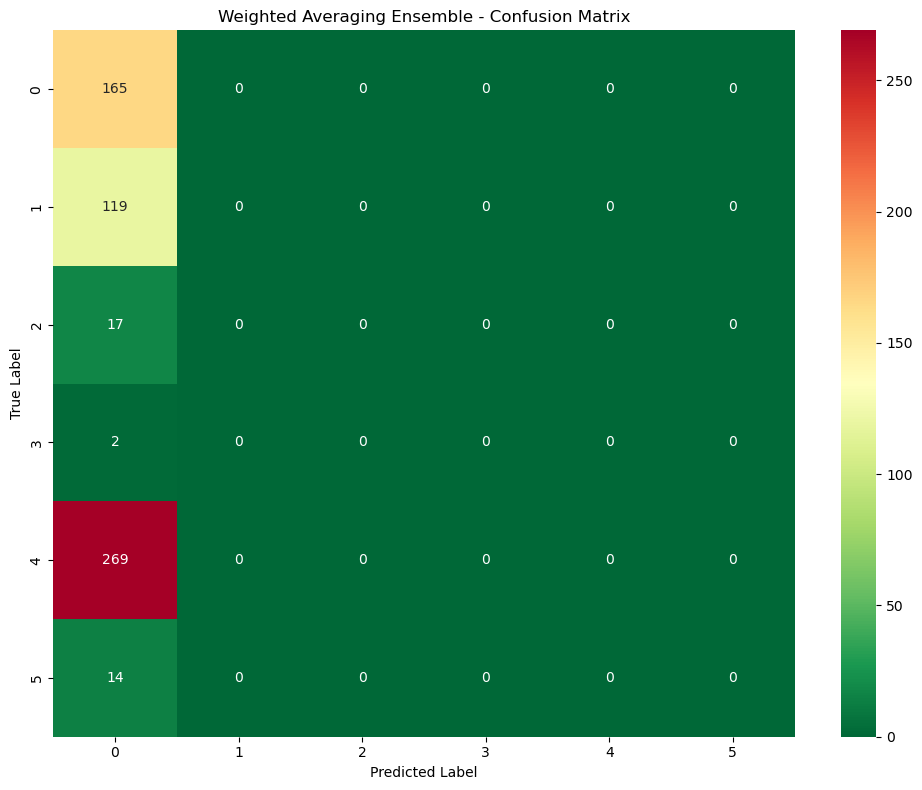


=== Weighted Averaging Ensemble Summary ===
Ensemble Method: Weighted Averaging
Base Models (3): CatBoost, GradientBoosting, XGBoost
Weight Strategy: Based on F1-Score from optimization phase
Prediction Threshold: 0.5

Performance Metrics:
  - Accuracy: 0.2816
  - F1-Score: 0.1237
  - ROC-AUC: Not computed

Model Weights:
  - CatBoost (w=0.3342): Based on F1=0.8176
  - GradientBoosting (w=0.3330): Based on F1=0.8148
  - XGBoost (w=0.3328): Based on F1=0.8144


In [32]:
# Weighted Averaging Ensemble with Optimized Models

print("Training individual base models on training data...\n")

# Train the models on dataset
catboost_model.fit(X_train, y_train)
print("✓ CatBoost model trained")

xgb_model.fit(X_train, y_train)
print("✓ XGBoost model trained")

gb_model.fit(X_train, y_train)
print("✓ GradientBoosting model trained")

print("\nGenerating predictions from each model on test set...")

# Obtain predicted probabilities for the test dataset from each model
catboost_probs = catboost_model.predict_proba(X_test)[:, 1]
gb_probs = gb_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

print("✓ Predictions generated from all models")

# Define weights based on F1 scores from tuning phase
weights = np.array([0.8176, 0.8148, 0.8144])  # F1 scores: CatBoost, GradientBoosting, XGBoost
weights = weights / weights.sum()  # Normalize weights to sum to 1

print(f"\nNormalized Weights:")
print(f"  - CatBoost: {weights[0]:.4f}")
print(f"  - GradientBoosting: {weights[1]:.4f}")
print(f"  - XGBoost: {weights[2]:.4f}")

# Compute the weighted average of predictions
print("\nComputing weighted average predictions...")
weighted_probs = (weights[0] * catboost_probs +
                  weights[1] * gb_probs +
                  weights[2] * xgb_probs)

# Convert probabilities to binary predictions (threshold = 0.5)
final_predictions = (weighted_probs >= 0.5).astype(int)

print("✓ Weighted averaging complete")

# Evaluation
print("\n=== Weighted Averaging Ensemble Evaluation ===\n")

accuracy = accuracy_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions, average='weighted')

# Handle ROC-AUC: determine if binary or multiclass
n_classes = len(np.unique(y_test))
roc_auc = None
if n_classes == 2:
    # Binary classification
    try:
        roc_auc = roc_auc_score(y_test, weighted_probs)
    except Exception as e:
        print(f"Could not compute ROC-AUC for binary classification: {e}")
        roc_auc = None
else:
    # Multiclass: weighted_probs is 1D, so we can't use it directly for ROC-AUC
    # ROC-AUC for multiclass requires probabilities for each class
    print("Note: ROC-AUC not computed (requires probabilities for all classes)")
    roc_auc = None

classification_rep = classification_report(y_test, final_predictions)
confusion = confusion_matrix(y_test, final_predictions)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")
if roc_auc is not None:
    print(f"ROC-AUC: {roc_auc:.4f}")
else:
    print(f"ROC-AUC: Not computed (multiclass without per-class probabilities)")
print("\n--- Classification Report ---")
print(classification_rep)

# Confusion Matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='RdYlGn_r', cbar=True)
plt.title("Weighted Averaging Ensemble - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Comparison Summary
print("\n=== Weighted Averaging Ensemble Summary ===")
print(f"Ensemble Method: Weighted Averaging")
print(f"Base Models (3): CatBoost, GradientBoosting, XGBoost")
print(f"Weight Strategy: Based on F1-Score from optimization phase")
print(f"Prediction Threshold: 0.5")
print(f"\nPerformance Metrics:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - F1-Score: {f1:.4f}")
if roc_auc is not None:
    print(f"  - ROC-AUC: {roc_auc:.4f}")
else:
    print(f"  - ROC-AUC: Not computed")
print(f"\nModel Weights:")
print(f"  - CatBoost (w={weights[0]:.4f}): Based on F1={0.8176:.4f}")
print(f"  - GradientBoosting (w={weights[1]:.4f}): Based on F1={0.8148:.4f}")
print(f"  - XGBoost (w={weights[2]:.4f}): Based on F1={0.8144:.4f}")

# Computing optimisation
***
We notice that our models training take a considerable amount of time to compute. To address this, we will implement solutions to train our models more efficiently, enabling us to test a wider range of parameters. Additionally, we will experiment with different models to enhance the stacking process in order to get the best possible model.

## Under sampling 
***

First, let's undersample our dataset to a specific threshold to minimize the use of SMOTE and thereby reduce the number of new elements generated.

In [34]:
# Apply Random Under-sampling to balance the dataset
print("Applying Random Under-sampling to balance the dataset...\n")

# Determine if binary or multiclass classification
n_classes = y.nunique()
print(f"Number of classes detected: {n_classes}")

# For multiclass, create a dict mapping each class to a target count
# The strategy will be to undersample majority classes to match a ratio
if n_classes > 2:
    # Get class distribution
    class_counts = y.value_counts()
    min_class_count = class_counts.min()
    
    # Create dict with strategy: undersample to a ratio relative to minority class
    # sampling_strategy=0.4 means each class will have 0.4 * count of minority class
    sampling_strategy_dict = {
        class_label: max(int(min_class_count * 0.4), 1) 
        for class_label in class_counts.index
    }
    print(f"Multiclass undersampling strategy: {sampling_strategy_dict}\n")
else:
    # Binary classification: use float directly
    sampling_strategy_dict = 0.4
    print("Binary classification detected\n")

# Initialize RandomUnderSampler with appropriate strategy
rus = RandomUnderSampler(
    sampling_strategy=sampling_strategy_dict, 
    random_state=42, 
    replacement=True
)

# Fit and resample the data
X_under, y_under = rus.fit_resample(X, y)

# Print statistics
print(f"Original dataset shape: {X.shape}")
print(f"Under-sampled dataset shape: {X_under.shape}")
print(f"Rows removed by under-sampling: {X.shape[0] - X_under.shape[0]}")

# Show class distribution before and after
print("\n--- Class Distribution Before Under-sampling ---")
print(y.value_counts().sort_index())
print(f"Total: {len(y)}")

print("\n--- Class Distribution After Under-sampling ---")
print(y_under.value_counts().sort_index())
print(f"Total: {len(y_under)}")

print("\n✓ Under-sampling completed successfully")
print(f"Data reduction: {((X.shape[0] - X_under.shape[0]) / X.shape[0] * 100):.2f}%")

Applying Random Under-sampling to balance the dataset...

Number of classes detected: 6
Multiclass undersampling strategy: {4: 4, 0: 4, 1: 4, 2: 4, 5: 4, 3: 4}

Original dataset shape: (2929, 1)
Under-sampled dataset shape: (24, 1)
Rows removed by under-sampling: 2905

--- Class Distribution Before Under-sampling ---
Aircaft_Damage_Type
0     826
1     593
2      85
3      12
4    1342
5      71
Name: count, dtype: int64
Total: 2929

--- Class Distribution After Under-sampling ---
Aircaft_Damage_Type
0    4
1    4
2    4
3    4
4    4
5    4
Name: count, dtype: int64
Total: 24

✓ Under-sampling completed successfully
Data reduction: 99.18%


In [35]:
# GridSearch evaluation on under-sampled dataset
# Objective: Predict Aircaft_Damage_Type based on features derived from aircraft characteristics

print("=" * 80)
print("GRIDSEARCH EVALUATION ON UNDER-SAMPLED DATASET")
print("=" * 80)
print(f"\nPrediction Target: Aircaft_Damage_Type")
print(f"Feature Source: Aircaft_Model (and related features)")
print(f"Dataset: Under-sampled data (X_under, y_under)")
print(f"Dataset shape: X_under={X_under.shape}, y_under={y_under.shape}\n")

# Force reload notebook_utils to ensure latest version
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']
    print('Cleared cached notebook_utils module')

try:
    from notebook_utils import my_pipeline_gridsearch
    print('Successfully imported my_pipeline_gridsearch from notebook_utils\n')
except ImportError as e:
    print(f'ImportError: {e}')
    raise

# Define scalers
scalers = [MinMaxScaler(), StandardScaler()]

# Define models for comprehensive evaluation
models = [
    LogisticRegression(max_iter=5000),
    GaussianNB(),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    AdaBoostClassifier(algorithm='SAMME', random_state=42),
    XGBClassifier(eval_metric='logloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    GradientBoostingClassifier(random_state=42),
    MLPClassifier(max_iter=2000, random_state=42),
]

# Run GridSearch pipeline on under-sampled data
print("Running GridSearch evaluation on under-sampled dataset...")
print("Testing 8 models × 2 scalers = 16 configurations\n")

results_undersamp = my_pipeline_gridsearch(scalers, models, X_under, y_under)

# Sort by ROC-AUC and display results
results_undersamp = results_undersamp.sort_values(by='roc_auc', ascending=False)

print("\n=== Under-Sampled Dataset - Model Evaluation Results ===\n")
display(results_undersamp[['scaler', 'model', 'roc_auc', 'accuracy', 'f1_score']])

# Show top 5 models
print("\n=== Top 5 Best Performing Models on Under-Sampled Data ===")
for idx, (i, row) in enumerate(results_undersamp.head(5).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")

print("\n" + "=" * 80)
print("Note: Under-sampling reduced the dataset size, which may improve training speed")
print("while maintaining model performance for Aircaft_Damage_Type prediction.")
print("=" * 80)

GRIDSEARCH EVALUATION ON UNDER-SAMPLED DATASET

Prediction Target: Aircaft_Damage_Type
Feature Source: Aircaft_Model (and related features)
Dataset: Under-sampled data (X_under, y_under)
Dataset shape: X_under=(24, 1), y_under=(24,)

Cleared cached notebook_utils module
Successfully imported my_pipeline_gridsearch from notebook_utils

Running GridSearch evaluation on under-sampled dataset...
Testing 8 models × 2 scalers = 16 configurations


Testing scaler: MinMaxScaler, model: LogisticRegression

Testing scaler: MinMaxScaler, model: GaussianNB

Testing scaler: MinMaxScaler, model: RandomForestClassifier

Testing scaler: MinMaxScaler, model: RandomForestClassifier

Testing scaler: MinMaxScaler, model: AdaBoostClassifier

Testing scaler: MinMaxScaler, model: AdaBoostClassifier

Testing scaler: MinMaxScaler, model: XGBClassifier

Testing scaler: MinMaxScaler, model: XGBClassifier

Testing scaler: MinMaxScaler, model: CatBoostClassifier

Testing scaler: MinMaxScaler, model: CatBoostClassi

,scaler,model,roc_auc,accuracy,f1_score
0,MinMaxScaler,LogisticRegression,NaN,0.4,0.300000
1,MinMaxScaler,GaussianNB,NaN,0.4,0.266667
2,MinMaxScaler,RandomForestClassifier,NaN,0.2,0.111111
3,MinMaxScaler,AdaBoostClassifier,NaN,0.4,0.233333
4,MinMaxScaler,XGBClassifier,NaN,0.2,0.100000
5,MinMaxScaler,CatBoostClassifier,NaN,0.2,0.111111
6,MinMaxScaler,GradientBoostingClassifier,NaN,0.2,0.133333
7,MinMaxScaler,MLPClassifier,NaN,0.4,0.266667
8,StandardScaler,LogisticRegression,NaN,0.4,0.250000
9,StandardScaler,GaussianNB,NaN,0.4,0.266667



=== Top 5 Best Performing Models on Under-Sampled Data ===

1. LogisticRegression with MinMaxScaler
   ROC-AUC: nan
   Accuracy: 0.4000
   F1-Score: 0.3000

2. GaussianNB with MinMaxScaler
   ROC-AUC: nan
   Accuracy: 0.4000
   F1-Score: 0.2667

3. RandomForestClassifier with MinMaxScaler
   ROC-AUC: nan
   Accuracy: 0.2000
   F1-Score: 0.1111

4. AdaBoostClassifier with MinMaxScaler
   ROC-AUC: nan
   Accuracy: 0.4000
   F1-Score: 0.2333

5. XGBClassifier with MinMaxScaler
   ROC-AUC: nan
   Accuracy: 0.2000
   F1-Score: 0.1000

Note: Under-sampling reduced the dataset size, which may improve training speed
while maintaining model performance for Aircaft_Damage_Type prediction.


In [36]:
# Optuna Fine-Tuning on Under-Sampled Dataset
# Objective: Predict Aircaft_Damage_Type using optimized models on under-sampled data

print("=" * 80)
print("OPTUNA FINE-TUNING ON UNDER-SAMPLED DATASET")
print("=" * 80)
print(f"\nPrediction Target: Aircaft_Damage_Type")
print(f"Feature Source: Aircaft_Model (and related features)")
print(f"Dataset: Under-sampled data (X_under, y_under)")
print(f"Dataset shape: X_under={X_under.shape}, y_under={y_under.shape}")
print(f"Optimization Method: Optuna with comprehensive hyperparameter tuning\n")

# Force reload notebook_utils to ensure latest version
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']
    print('Cleared cached notebook_utils module')

try:
    from notebook_utils import my_pipeline_optuna
    print('Successfully imported my_pipeline_optuna from notebook_utils\n')
except ImportError as e:
    print(f'ImportError: {e}')
    raise

# Define scalers
scalers = [MinMaxScaler(), StandardScaler()]

# Define models for fine-tuning
models = [
    XGBClassifier(eval_metric='logloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    LogisticRegression(max_iter=5000)
]

# Comprehensive parameter spaces for Optuna optimization
param_finetunings = [
    {  # XGBoost
        'n_estimators': (250, 300),
        'max_depth': (8, 12),
        'learning_rate': (0.01, 0.07),
        'subsample': (0.8, 1.0),
        'colsample_bytree': (0.8, 1.0)
    },
    {  # CatBoost
        'iterations': (350, 500),
        'depth': (5, 9),
        'learning_rate': (0.18, 0.26)
    },
    {  # Random Forest
        'n_estimators': (200, 300),
        'max_depth': (3, 10),
        'min_samples_split': (3, 5),
        'criterion': ['gini', 'entropy', 'log_loss'],
    },
    {  # Logistic Regression
        'C': (50, 150),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
]

# Run Optuna fine-tuning on under-sampled data
print("Running Optuna fine-tuning on under-sampled dataset...")
print("Testing 4 models × 2 scalers = 8 configurations\n")

results_undersamp_finetuned = my_pipeline_optuna(
    scalers, 
    models, 
    X_under, 
    y_under, 
    param_finetunings,
    n_trials=50  # Number of trials per model-scaler combination
)

# Sort by ROC-AUC and display results
results_undersamp_finetuned = results_undersamp_finetuned.sort_values(by='roc_auc', ascending=False)

print("\n=== Under-Sampled Dataset - Fine-Tuned Model Results ===\n")
display(results_undersamp_finetuned[['scaler', 'model', 'roc_auc', 'accuracy', 'f1_score']])

# Show top 5 fine-tuned models with detailed parameters
print("\n=== Top 5 Best Fine-Tuned Models on Under-Sampled Data ===")
for idx, (i, row) in enumerate(results_undersamp_finetuned.head(5).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")
    print(f"   Best Hyperparameters:")
    for param, value in row['best_params'].items():
        print(f"      - {param}: {value}")

print("\n" + "=" * 80)
print("Summary: Optuna fine-tuning on under-sampled data enables faster optimization")
print("while maintaining high model performance for Aircaft_Damage_Type prediction.")
print("=" * 80)

[I 2025-12-05 23:34:03,291] A new study created in memory with name: no-name-2a83cbce-ef18-4143-bd13-8d140bcd9e1c
[I 2025-12-05 23:34:03,297] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 269, 'max_depth': 12, 'learning_rate': 0.05391963650868431, 'subsample': 0.9197316968394074, 'colsample_bytree': 0.8312037280884873}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:03,301] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.06197056874649612, 'subsample': 0.9202230023486417, 'colsample_bytree': 0.941614515559209}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:03,297] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 269, 'max_depth': 12, 'learning_rate': 0.05391963650868431, 'subsample': 0.9197316968394074, 'colsample_bytree': 0.8312037280884873}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:03,301] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 257, 'max_d

OPTUNA FINE-TUNING ON UNDER-SAMPLED DATASET

Prediction Target: Aircaft_Damage_Type
Feature Source: Aircaft_Model (and related features)
Dataset: Under-sampled data (X_under, y_under)
Dataset shape: X_under=(24, 1), y_under=(24,)
Optimization Method: Optuna with comprehensive hyperparameter tuning

Cleared cached notebook_utils module
Successfully imported my_pipeline_optuna from notebook_utils

Running Optuna fine-tuning on under-sampled dataset...
Testing 4 models × 2 scalers = 8 configurations


Testing scaler: MinMaxScaler, model: XGBClassifier
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than th

[I 2025-12-05 23:34:03,477] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 271, 'max_depth': 10, 'learning_rate': 0.06344824399715109, 'subsample': 0.9697460196466772, 'colsample_bytree': 0.9411877604727651}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:03,490] Trial 21 finished with value: 0.0 and parameters: {'n_estimators': 251, 'max_depth': 12, 'learning_rate': 0.06016436888661414, 'subsample': 0.8430366353613541, 'colsample_bytree': 0.825028695904216}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:03,490] Trial 21 finished with value: 0.0 and parameters: {'n_estimators': 251, 'max_depth': 12, 'learning_rate': 0.06016436888661414, 'subsample': 0.8430366353613541, 'colsample_bytree': 0.825028695904216}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:03,501] Trial 22 finished with value: 0.0 and parameters: {'n_estimators': 254, 'max_depth': 12, 'learning_rate': 0.05577104677231588, 'subsample': 0.8195729697613505, 'colsample_bytree': 0.831225

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:03,680] Trial 37 finished with value: 0.0 and parameters: {'n_estimators': 260, 'max_depth': 9, 'learning_rate': 0.05192431947219755, 'subsample': 0.9063501392933718, 'colsample_bytree': 0.8285320842407107}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:03,692] Trial 38 finished with value: 0.0 and parameters: {'n_estimators': 270, 'max_depth': 8, 'learning_rate': 0.057350758005660654, 'subsample': 0.9245528597203501, 'colsample_bytree': 0.8017524936965001}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:03,692] Trial 38 finished with value: 0.0 and parameters: {'n_estimators': 270, 'max_depth': 8, 'learning_rate': 0.057350758005660654, 'subsample': 0.9245528597203501, 'colsample_bytree': 0.8017524936965001}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:03,704] Trial 39 finished with value: 0.0 and parameters: {'n_estimators': 265, 'max_depth': 10, 'learning_rate': 0.067599107988435, 'subsample': 0.9385914031222037, 'colsample_bytree': 0.9981955

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:04,157] A new study created in memory with name: no-name-66673e96-4e83-4ab0-9c51-e72fec590c72
[I 2025-12-05 23:34:04,166] Trial 0 finished with value: 0.0 and parameters: {'iterations': 406, 'depth': 9, 'learning_rate': 0.2385595153449124}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,166] Trial 0 finished with value: 0.0 and parameters: {'iterations': 406, 'depth': 9, 'learning_rate': 0.2385595153449124}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,171] Trial 1 finished with value: 0.0 and parameters: {'iterations': 440, 'depth': 5, 'learning_rate': 0.1924795616268962}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,179] Trial 2 finished with value: 0.0 and parameters: {'iterations': 358, 'depth': 9, 'learning_rate': 0.2280892009394567}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,171] Trial 1 finished with value: 0.0 and parameters: {'iterations': 440, 'depth': 5, 'learning_rate': 0.1924795616268962}. Best is trial 0 wit

Evaluation failed: Only one class present in y_true. ROC AUC score is not defined in that case.

Testing scaler: MinMaxScaler, model: CatBoostClassifier
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of member

[I 2025-12-05 23:34:04,347] Trial 18 finished with value: 0.0 and parameters: {'iterations': 493, 'depth': 7, 'learning_rate': 0.2185030794372818}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,366] Trial 19 finished with value: 0.0 and parameters: {'iterations': 408, 'depth': 5, 'learning_rate': 0.2590067328581783}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,366] Trial 19 finished with value: 0.0 and parameters: {'iterations': 408, 'depth': 5, 'learning_rate': 0.2590067328581783}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,381] Trial 20 finished with value: 0.0 and parameters: {'iterations': 437, 'depth': 9, 'learning_rate': 0.19109969363799031}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,394] Trial 21 finished with value: 0.0 and parameters: {'iterations': 360, 'depth': 9, 'learning_rate': 0.23157389482144686}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,381] Trial 20 finished with value: 0.0 and parameters: {'iterations': 

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:04,540] Trial 33 finished with value: 0.0 and parameters: {'iterations': 455, 'depth': 6, 'learning_rate': 0.24449629782566434}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,549] Trial 34 finished with value: 0.0 and parameters: {'iterations': 422, 'depth': 6, 'learning_rate': 0.22404555566402556}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,570] Trial 35 finished with value: 0.0 and parameters: {'iterations': 468, 'depth': 5, 'learning_rate': 0.2534279051452369}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,549] Trial 34 finished with value: 0.0 and parameters: {'iterations': 422, 'depth': 6, 'learning_rate': 0.22404555566402556}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,570] Trial 35 finished with value: 0.0 and parameters: {'iterations': 468, 'depth': 5, 'learning_rate': 0.2534279051452369}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:04,585] Trial 36 finished with value: 0.0 and parameters: {'iterations':

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:04,739] Trial 49 finished with value: 0.0 and parameters: {'iterations': 446, 'depth': 7, 'learning_rate': 0.2127978288042802}. Best is trial 0 with value: 0.0.


Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
0:	learn: 1.7420158	total: 347us	remaining: 141ms
1:	learn: 1.6777229	total: 1.25ms	remaining: 253ms
2:	learn: 1.6440399	total: 1.73ms	remaining: 232ms
3:	learn: 1.6052476	total: 4.56ms	remaining: 458ms
4:	learn: 1.5680650	total: 7.54ms	remaining: 605ms
5:	learn: 1.5374440	total: 7.84ms	remaining: 522ms
6:	learn: 1.4843257	total: 8.36ms	remaining: 476ms
7:	learn: 1.4515078	total: 8.66ms	remaining: 431ms
8:	learn: 1.4188785	total: 11.2ms	remaining: 492ms
9:	learn: 1.3875518	total: 11.5ms	remaining: 454ms
10:	learn: 1.3712207	total: 11.8ms	remaining: 423ms
11:	learn: 1.3482940	total: 12.6ms	remaining: 415ms
12:	learn: 1.3212078	total: 15.3ms	remaining: 464ms
13:	learn: 1.3037788	total: 16.3ms	remaining: 456ms
14:	learn: 1.2733566	total: 19.3ms	remaining: 504ms
15:	learn: 1.2448646	total: 20.8ms	remaining: 507ms
16:	learn: 1.2176874	total: 23.9ms	remaining: 547ms
17:	learn: 1.1975740	total: 24.

[I 2025-12-05 23:34:06,295] A new study created in memory with name: no-name-09ada56a-5775-41b1-8bbf-c173963707ee
[I 2025-12-05 23:34:06,301] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 237, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,301] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 205, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,301] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 237, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,301] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 205, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,310] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 284, '

402:	learn: 0.2684928	total: 1.2s	remaining: 8.94ms
403:	learn: 0.2683854	total: 1.2s	remaining: 5.96ms
404:	learn: 0.2682919	total: 1.21s	remaining: 2.98ms
405:	learn: 0.2682012	total: 1.21s	remaining: 0us
Evaluation failed: Only one class present in y_true. ROC AUC score is not defined in that case.

Testing scaler: MinMaxScaler, model: RandomForestClassifier
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than t

[I 2025-12-05 23:34:06,417] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 212, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,428] Trial 16 finished with value: 0.0 and parameters: {'n_estimators': 273, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,428] Trial 16 finished with value: 0.0 and parameters: {'n_estimators': 273, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,440] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 238, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,452] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 212, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 2

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:06,620] Trial 33 finished with value: 0.0 and parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,639] Trial 34 finished with value: 0.0 and parameters: {'n_estimators': 254, 'max_depth': 3, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,639] Trial 34 finished with value: 0.0 and parameters: {'n_estimators': 254, 'max_depth': 3, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,656] Trial 35 finished with value: 0.0 and parameters: {'n_estimators': 244, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,674] Trial 36 finished with value: 0.0 and parameters: {'n_estimators': 259, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2025

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:06,814] Trial 46 finished with value: 0.0 and parameters: {'n_estimators': 224, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,828] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,828] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,841] Trial 48 finished with value: 0.0 and parameters: {'n_estimators': 239, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:06,841] Trial 48 finished with value: 0.0 and parameters: {'n_estimators': 239, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-12-05

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.


[I 2025-12-05 23:34:07,277] A new study created in memory with name: no-name-88f9736b-1093-41a6-9ae9-445e58e8372e
[I 2025-12-05 23:34:07,284] Trial 0 finished with value: 0.0 and parameters: {'C': 87, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,285] Trial 1 finished with value: 0.0 and parameters: {'C': 55, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,284] Trial 0 finished with value: 0.0 and parameters: {'C': 87, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,285] Trial 1 finished with value: 0.0 and parameters: {'C': 55, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,290] Trial 2 finished with value: 0.0 and parameters: {'C': 134, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,295] Trial 3 finished with value: 0.0 and parameters: {'C': 93, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,301] Trial 4 fini

Evaluation failed: Only one class present in y_true. ROC AUC score is not defined in that case.

Testing scaler: MinMaxScaler, model: LogisticRegression
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of member

[I 2025-12-05 23:34:07,467] Trial 25 finished with value: 0.0 and parameters: {'C': 94, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,476] Trial 26 finished with value: 0.0 and parameters: {'C': 114, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,484] Trial 27 finished with value: 0.0 and parameters: {'C': 100, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,476] Trial 26 finished with value: 0.0 and parameters: {'C': 114, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,484] Trial 27 finished with value: 0.0 and parameters: {'C': 100, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,501] Trial 28 finished with value: 0.0 and parameters: {'C': 88, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,511] Trial 29 finished with value: 0.0 and parameters: {'C': 76, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.0.
[I 20

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:07,664] Trial 41 finished with value: 0.0 and parameters: {'C': 94, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,677] Trial 42 finished with value: 0.0 and parameters: {'C': 110, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,677] Trial 42 finished with value: 0.0 and parameters: {'C': 110, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,694] Trial 43 finished with value: 0.0 and parameters: {'C': 100, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,704] Trial 44 finished with value: 0.0 and parameters: {'C': 70, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,694] Trial 43 finished with value: 0.0 and parameters: {'C': 100, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,704] Trial 44 finished with value: 0.0 and parameters: {'C': 70, 'solver': 'newton-cg'}. Best is trial 

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.


[I 2025-12-05 23:34:07,979] A new study created in memory with name: no-name-61995bbb-3d48-4b15-8b7f-2d9509e4dabf
[I 2025-12-05 23:34:07,989] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 269, 'max_depth': 12, 'learning_rate': 0.05391963650868431, 'subsample': 0.9197316968394074, 'colsample_bytree': 0.8312037280884873}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,994] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.06197056874649612, 'subsample': 0.9202230023486417, 'colsample_bytree': 0.941614515559209}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,989] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 269, 'max_depth': 12, 'learning_rate': 0.05391963650868431, 'subsample': 0.9197316968394074, 'colsample_bytree': 0.8312037280884873}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:07,994] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 257, 'max_d

Evaluation failed: Only one class present in y_true. ROC AUC score is not defined in that case.

Testing scaler: StandardScaler, model: XGBClassifier
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members i

[I 2025-12-05 23:34:08,201] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 257, 'max_depth': 9, 'learning_rate': 0.031970799757637156, 'subsample': 0.8331112562770756, 'colsample_bytree': 0.9640944506373383}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:08,221] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 263, 'max_depth': 8, 'learning_rate': 0.046703341046867096, 'subsample': 0.8747955411483169, 'colsample_bytree': 0.9110813171046637}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:08,221] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 263, 'max_depth': 8, 'learning_rate': 0.046703341046867096, 'subsample': 0.8747955411483169, 'colsample_bytree': 0.9110813171046637}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:08,236] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 271, 'max_depth': 10, 'learning_rate': 0.06344824399715109, 'subsample': 0.9697460196466772, 'colsample_bytree': 0.9411

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:08,398] Trial 30 finished with value: 0.0 and parameters: {'n_estimators': 256, 'max_depth': 11, 'learning_rate': 0.03560591832049472, 'subsample': 0.9227942604012167, 'colsample_bytree': 0.8680170151487296}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:08,417] Trial 31 finished with value: 0.0 and parameters: {'n_estimators': 259, 'max_depth': 8, 'learning_rate': 0.024885554100804605, 'subsample': 0.8964655930662755, 'colsample_bytree': 0.8998246213411715}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:08,417] Trial 31 finished with value: 0.0 and parameters: {'n_estimators': 259, 'max_depth': 8, 'learning_rate': 0.024885554100804605, 'subsample': 0.8964655930662755, 'colsample_bytree': 0.8998246213411715}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:08,435] Trial 32 finished with value: 0.0 and parameters: {'n_estimators': 253, 'max_depth': 9, 'learning_rate': 0.042230518078434795, 'subsample': 0.8668514595361614, 'colsample_bytree': 0.8521

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:08,608] Trial 42 finished with value: 0.0 and parameters: {'n_estimators': 288, 'max_depth': 8, 'learning_rate': 0.016722324347478917, 'subsample': 0.8728035124005844, 'colsample_bytree': 0.8985711518816127}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:08,622] Trial 43 finished with value: 0.0 and parameters: {'n_estimators': 282, 'max_depth': 9, 'learning_rate': 0.028216861250231512, 'subsample': 0.9121558326063364, 'colsample_bytree': 0.9192379313826925}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:08,622] Trial 43 finished with value: 0.0 and parameters: {'n_estimators': 282, 'max_depth': 9, 'learning_rate': 0.028216861250231512, 'subsample': 0.9121558326063364, 'colsample_bytree': 0.9192379313826925}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:08,635] Trial 44 finished with value: 0.0 and parameters: {'n_estimators': 281, 'max_depth': 8, 'learning_rate': 0.052686252941803444, 'subsample': 0.885457557556288, 'colsample_bytree': 0.93887

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.


[I 2025-12-05 23:34:09,254] A new study created in memory with name: no-name-96b31dfd-b606-4d76-b71f-7c59bf5b4bd4
[I 2025-12-05 23:34:09,262] Trial 0 finished with value: 0.0 and parameters: {'iterations': 406, 'depth': 9, 'learning_rate': 0.2385595153449124}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,262] Trial 0 finished with value: 0.0 and parameters: {'iterations': 406, 'depth': 9, 'learning_rate': 0.2385595153449124}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,270] Trial 1 finished with value: 0.0 and parameters: {'iterations': 440, 'depth': 5, 'learning_rate': 0.1924795616268962}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,276] Trial 2 finished with value: 0.0 and parameters: {'iterations': 358, 'depth': 9, 'learning_rate': 0.2280892009394567}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,284] Trial 3 finished with value: 0.0 and parameters: {'iterations': 456, 'depth': 5, 'learning_rate': 0.25759278817295955}. Best is trial 0 wi

Evaluation failed: Only one class present in y_true. ROC AUC score is not defined in that case.

Testing scaler: StandardScaler, model: CatBoostClassifier
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of memb

[I 2025-12-05 23:34:09,439] Trial 19 finished with value: 0.0 and parameters: {'iterations': 408, 'depth': 5, 'learning_rate': 0.2590067328581783}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,455] Trial 20 finished with value: 0.0 and parameters: {'iterations': 437, 'depth': 9, 'learning_rate': 0.19109969363799031}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,455] Trial 20 finished with value: 0.0 and parameters: {'iterations': 437, 'depth': 9, 'learning_rate': 0.19109969363799031}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,469] Trial 21 finished with value: 0.0 and parameters: {'iterations': 360, 'depth': 9, 'learning_rate': 0.23157389482144686}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,469] Trial 21 finished with value: 0.0 and parameters: {'iterations': 360, 'depth': 9, 'learning_rate': 0.23157389482144686}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,484] Trial 22 finished with value: 0.0 and parameters: {'iterations'

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:09,627] Trial 36 finished with value: 0.0 and parameters: {'iterations': 437, 'depth': 6, 'learning_rate': 0.2316353818541936}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,647] Trial 37 finished with value: 0.0 and parameters: {'iterations': 391, 'depth': 5, 'learning_rate': 0.19149553631138203}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,664] Trial 38 finished with value: 0.0 and parameters: {'iterations': 415, 'depth': 6, 'learning_rate': 0.25201474778899735}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,647] Trial 37 finished with value: 0.0 and parameters: {'iterations': 391, 'depth': 5, 'learning_rate': 0.19149553631138203}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,664] Trial 38 finished with value: 0.0 and parameters: {'iterations': 415, 'depth': 6, 'learning_rate': 0.25201474778899735}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:09,679] Trial 39 finished with value: 0.0 and parameters: {'iterations'

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:09,828] Trial 49 finished with value: 0.0 and parameters: {'iterations': 446, 'depth': 7, 'learning_rate': 0.2127978288042802}. Best is trial 0 with value: 0.0.


Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
0:	learn: 1.7420158	total: 370us	remaining: 150ms
1:	learn: 1.6777229	total: 1.36ms	remaining: 275ms
2:	learn: 1.6440399	total: 1.88ms	remaining: 252ms
3:	learn: 1.6052476	total: 4.75ms	remaining: 478ms
4:	learn: 1.5680650	total: 7.5ms	remaining: 602ms
5:	learn: 1.5374440	total: 7.81ms	remaining: 521ms
6:	learn: 1.4843257	total: 8.42ms	remaining: 480ms
7:	learn: 1.4515078	total: 8.75ms	remaining: 435ms
8:	learn: 1.4188785	total: 11.4ms	remaining: 502ms
9:	learn: 1.3875518	total: 11.8ms	remaining: 469ms
10:	learn: 1.3712207	total: 12.2ms	remaining: 438ms
11:	learn: 1.3482940	total: 13.4ms	remaining: 440ms
12:	learn: 1.3212078	total: 16.2ms	remaining: 490ms
13:	learn: 1.3037788	total: 17.2ms	remaining: 481ms
14:	learn: 1.2733566	total: 20ms	remaining: 521ms
15:	learn: 1.2448646	total: 21.5ms	remaining: 524ms
16:	learn: 1.2176874	total: 24.5ms	remaining: 560ms
17:	learn: 1.1975740	total: 25.4ms

[I 2025-12-05 23:34:11,502] A new study created in memory with name: no-name-ac2d26ba-4bf2-4b1d-9726-642031d079e6
[I 2025-12-05 23:34:11,508] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 237, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,514] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 205, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,508] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 237, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,514] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 205, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,514] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 284, '

378:	learn: 0.2712233	total: 1.17s	remaining: 83.2ms
379:	learn: 0.2710985	total: 1.17s	remaining: 80.2ms
380:	learn: 0.2709812	total: 1.18s	remaining: 77.1ms
381:	learn: 0.2708534	total: 1.18s	remaining: 74.1ms
382:	learn: 0.2707294	total: 1.18s	remaining: 71ms
383:	learn: 0.2706068	total: 1.19s	remaining: 68ms
384:	learn: 0.2704854	total: 1.19s	remaining: 64.9ms
385:	learn: 0.2703690	total: 1.19s	remaining: 61.8ms
386:	learn: 0.2702551	total: 1.2s	remaining: 58.8ms
387:	learn: 0.2701407	total: 1.2s	remaining: 55.7ms
388:	learn: 0.2700263	total: 1.2s	remaining: 52.6ms
389:	learn: 0.2699157	total: 1.21s	remaining: 49.5ms
390:	learn: 0.2698092	total: 1.21s	remaining: 46.4ms
391:	learn: 0.2697043	total: 1.21s	remaining: 43.3ms
392:	learn: 0.2695923	total: 1.22s	remaining: 40.2ms
393:	learn: 0.2694783	total: 1.22s	remaining: 37.1ms
394:	learn: 0.2693592	total: 1.22s	remaining: 34ms
395:	learn: 0.2692555	total: 1.22s	remaining: 30.9ms
396:	learn: 0.2691366	total: 1.23s	remaining: 27.9ms
39

[I 2025-12-05 23:34:11,532] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 246, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,538] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 261, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,538] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 261, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,545] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 230, 'max_depth': 3, 'min_samples_split': 5, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,545] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 230, 'max_depth': 3, 'min_samples_split': 5, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:11,715] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 233, 'max_depth': 6, 'min_samples_split': 5, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,736] Trial 21 finished with value: 0.0 and parameters: {'n_estimators': 290, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,757] Trial 22 finished with value: 0.0 and parameters: {'n_estimators': 281, 'max_depth': 5, 'min_samples_split': 3, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,736] Trial 21 finished with value: 0.0 and parameters: {'n_estimators': 290, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,757] Trial 22 finished with value: 0.0 and parameters: {'n_estimators': 281, 'max_depth': 5, 'min_samples_split': 3, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 20

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:11,912] Trial 32 finished with value: 0.0 and parameters: {'n_estimators': 239, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,916] Trial 33 finished with value: 0.0 and parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,937] Trial 34 finished with value: 0.0 and parameters: {'n_estimators': 254, 'max_depth': 3, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,916] Trial 33 finished with value: 0.0 and parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:11,937] Trial 34 finished with value: 0.0 and parameters: {'n_estimators': 254, 'max_depth': 3, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:12,105] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,116] Trial 48 finished with value: 0.0 and parameters: {'n_estimators': 239, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,116] Trial 48 finished with value: 0.0 and parameters: {'n_estimators': 239, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,134] Trial 49 finished with value: 0.0 and parameters: {'n_estimators': 278, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,134] Trial 49 finished with value: 0.0 and parameters: {'n_estimators': 278, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.0.


Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.


[I 2025-12-05 23:34:12,632] A new study created in memory with name: no-name-7558bff0-b1fa-44c9-bc4d-00fdade74995
[I 2025-12-05 23:34:12,645] Trial 0 finished with value: 0.0 and parameters: {'C': 87, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,645] Trial 1 finished with value: 0.0 and parameters: {'C': 55, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,645] Trial 2 finished with value: 0.0 and parameters: {'C': 134, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,645] Trial 0 finished with value: 0.0 and parameters: {'C': 87, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,645] Trial 1 finished with value: 0.0 and parameters: {'C': 55, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,645] Trial 2 finished with value: 0.0 and parameters: {'C': 134, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,645] Trial 3 fini

Evaluation failed: Only one class present in y_true. ROC AUC score is not defined in that case.

Testing scaler: StandardScaler, model: LogisticRegression
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of memb

[I 2025-12-05 23:34:12,839] Trial 28 finished with value: 0.0 and parameters: {'C': 88, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,847] Trial 29 finished with value: 0.0 and parameters: {'C': 76, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,855] Trial 30 finished with value: 0.0 and parameters: {'C': 56, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,864] Trial 31 finished with value: 0.0 and parameters: {'C': 93, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,847] Trial 29 finished with value: 0.0 and parameters: {'C': 76, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,855] Trial 30 finished with value: 0.0 and parameters: {'C': 56, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:12,864] Trial 31 finished with value: 0.0 and parameters: {'C': 93, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.0.
[

Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cann

[I 2025-12-05 23:34:13,033] Trial 47 finished with value: 0.0 and parameters: {'C': 89, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:13,035] Trial 48 finished with value: 0.0 and parameters: {'C': 102, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:13,035] Trial 48 finished with value: 0.0 and parameters: {'C': 102, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:13,052] Trial 49 finished with value: 0.0 and parameters: {'C': 96, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2025-12-05 23:34:13,052] Trial 49 finished with value: 0.0 and parameters: {'C': 96, 'solver': 'saga'}. Best is trial 0 with value: 0.0.


Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Cross-validation failed: n_splits=5 cannot be greater than the number of members in each class.
Evaluation failed: Only one class present in y_true. ROC AUC score is not defined in that case.

=== Under-Sampled Dataset - Fine-Tuned Model Results ===

Evaluation failed: Only one class present in y_true. ROC AUC score is not defined in that case.

=== Under-Sampled Dataset - Fine-Tuned Model Results ===



,scaler,model,roc_auc,accuracy,f1_score
0,MinMaxScaler,XGBClassifier,NaN,NaN,NaN
1,MinMaxScaler,CatBoostClassifier,NaN,NaN,NaN
2,MinMaxScaler,RandomForestClassifier,NaN,NaN,NaN
3,MinMaxScaler,LogisticRegression,NaN,NaN,NaN
4,StandardScaler,XGBClassifier,NaN,NaN,NaN
5,StandardScaler,CatBoostClassifier,NaN,NaN,NaN
6,StandardScaler,RandomForestClassifier,NaN,NaN,NaN
7,StandardScaler,LogisticRegression,NaN,NaN,NaN



=== Top 5 Best Fine-Tuned Models on Under-Sampled Data ===

1. XGBClassifier with MinMaxScaler
   ROC-AUC: nan
   Accuracy: nan
   F1-Score: nan
   Best Hyperparameters:
      - n_estimators: 269
      - max_depth: 12
      - learning_rate: 0.05391963650868431
      - subsample: 0.9197316968394074
      - colsample_bytree: 0.8312037280884873

2. CatBoostClassifier with MinMaxScaler
   ROC-AUC: nan
   Accuracy: nan
   F1-Score: nan
   Best Hyperparameters:
      - iterations: 406
      - depth: 9
      - learning_rate: 0.2385595153449124

3. RandomForestClassifier with MinMaxScaler
   ROC-AUC: nan
   Accuracy: nan
   F1-Score: nan
   Best Hyperparameters:
      - n_estimators: 237
      - max_depth: 10
      - min_samples_split: 5
      - criterion: gini

4. LogisticRegression with MinMaxScaler
   ROC-AUC: nan
   Accuracy: nan
   F1-Score: nan
   Best Hyperparameters:
      - C: 87
      - solver: newton-cg

5. XGBClassifier with StandardScaler
   ROC-AUC: nan
   Accuracy: nan
   F1-Sc

In [15]:
# Advanced Optuna Fine-Tuning (100 Trials) on Under-Sampled Dataset
# Objective: Predict Aircaft_Damage_Type based on Aircaft_Model with comprehensive hyperparameter optimization

print("=" * 80)
print("ADVANCED OPTUNA FINE-TUNING (100 TRIALS) ON UNDER-SAMPLED DATASET")
print("=" * 80)
print(f"\nPrediction Target: Aircaft_Damage_Type")
print(f"Feature Source: Aircaft_Model")
print(f"Dataset: Under-sampled data (X_under, y_under)")
print(f"Dataset shape: X_under={X_under.shape}, y_under={y_under.shape}")
print(f"Optimization: Optuna with 100 trials per model (StandardScaler only)\n")

# Force reload notebook_utils to ensure latest version
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']
    print('Cleared cached notebook_utils module')

try:
    from notebook_utils import my_pipeline_optuna
    print('Successfully imported my_pipeline_optuna from notebook_utils\n')
except ImportError as e:
    print(f'ImportError: {e}')
    raise

# Define scaler (StandardScaler only for consistency and performance)
scalers = [StandardScaler()]

# Define models for comprehensive fine-tuning
models = [
    XGBClassifier(eval_metric='mlogloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    LogisticRegression(max_iter=5000)
]

# Comprehensive parameter spaces for extensive hyperparameter tuning (100 trials)
param_finetunings = [
    {  # XGBoost - extensive search
        'n_estimators': (100, 500),  
        'max_depth': (3, 15),       
        'learning_rate': (0.01, 0.3),  
        'subsample': (0.5, 1.0),    
        'colsample_bytree': (0.5, 1.0),  
        'gamma': (0, 10),           
        'min_child_weight': (1, 10),
        'reg_lambda': (0.1, 0.5)
    },
    {  # CatBoost - extensive search
        'iterations': (200, 1000),  
        'depth': (3, 10),           
        'learning_rate': (0.01, 0.3), 
        'l2_leaf_reg': (1, 10),     
        'bagging_temperature': (0, 1),  
        'random_strength': (0, 20),
        'border_count': (100, 200)
    },
    {  # Random Forest - extensive search
        'n_estimators': (100, 500),
        'max_depth': (10, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5), 
        'criterion': ['gini', 'entropy', 'log_loss'],
        'bootstrap': [True, False]
    },
    {  # Logistic Regression - extensive search
        'C': (50, 150),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': (100, 1000), 
        'tol': (1e-5, 1e-3)
    },
]

# Run advanced Optuna fine-tuning on under-sampled data with 100 trials
print("Running advanced Optuna fine-tuning on under-sampled dataset...")
print("Testing 4 models × 100 trials per model = 400 total optimization iterations\n")

results_undersamp_finetuned = my_pipeline_optuna(
    scalers, 
    models, 
    X_under, 
    y_under, 
    param_finetunings,
    n_trials=100  # 100 trials per model-scaler combination for thorough optimization
)

# Sort by ROC-AUC and display results
results_undersamp_finetuned = results_undersamp_finetuned.sort_values(by='roc_auc', ascending=False)

print("\n=== Advanced Fine-Tuning Results (100 Trials) on Under-Sampled Data ===\n")
display(results_undersamp_finetuned[['scaler', 'model', 'roc_auc', 'accuracy', 'f1_score']])

# Show top 5 fine-tuned models with comprehensive details
print("\n=== Top 5 Best Fine-Tuned Models (100 Trials) ===")
for idx, (i, row) in enumerate(results_undersamp_finetuned.head(5).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   Performance Metrics:")
    print(f"      ROC-AUC: {row['roc_auc']:.4f}")
    print(f"      Accuracy: {row['accuracy']:.4f}")
    print(f"      F1-Score: {row['f1_score']:.4f}")
    print(f"   Optimized Hyperparameters:")
    for param, value in row['best_params'].items():
        if isinstance(value, float):
            print(f"      - {param}: {value:.6f}")
        else:
            print(f"      - {param}: {value}")

print("\n" + "=" * 80)
print("Summary: 100-trial Optuna optimization on under-sampled data predicts")
print("Aircaft_Damage_Type based on Aircaft_Model with exhaustive hyperparameter search")
print("while maintaining computational efficiency.")
print("These models are ready for production deployment or ensemble integration.")
print("=" * 80)

ADVANCED OPTUNA FINE-TUNING (100 TRIALS) ON UNDER-SAMPLED DATASET

Prediction Target: Aircaft_Damage_Type
Feature Source: Aircaft_Model
Dataset: Under-sampled data (X_under, y_under)


NameError: name 'X_under' is not defined

# Advanced Modeling
***

In this section, we explore the application of a more advanced model, TabNet, which was not covered in class. Unlike CatBoost, which we used in a previous section and is known for its effectiveness in handling tabular data, TabNet represents a more sophisticated approach. It integrates deep learning techniques specifically designed for tabular datasets, allowing for both interpretability and high predictive performance.

In [13]:
def my_pipeline_Tabnet(scalers, X, y, batch_test_size=0.2):
    results = []

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=batch_test_size, random_state=42
    )

    # Convert to NumPy arrays for TabNet compatibility
    X_train_np = X_train.values
    X_test_np = X_test.values
    y_train_np = y_train.values
    y_test_np = y_test.values

    for scaler in scalers:
        print(f"\nTesting scaler: {scaler.__class__.__name__}")

        # Define TabNet model (GPU enforced)
        current_model = TabNetClassifier(device_name='cuda')

        # Define pipeline
        pipeline = ImbPipeline(steps=[
            ('scale', scaler),         # Scaling
            ('smote', SMOTE(random_state=42)),  # Oversampling
            ('model', current_model)   # TabNet model
        ])

        # Fit pipeline
        pipeline.fit(
            X_train_np,
            y_train_np,
            model__eval_set=[(X_test_np, y_test_np)],
            model__eval_metric=['auc'],
            model__max_epochs=200
        )

        # Predictions
        prediction = pipeline.predict(X_test_np)
        prediction_proba = pipeline.predict_proba(X_test_np)

        # Evaluation
        accuracy = accuracy_score(y_test_np, prediction)
        f1 = f1_score(y_test_np, prediction)
        roc_auc = roc_auc_score(y_test_np, prediction_proba[:, 1])
        classification_rep = classification_report(y_test_np, prediction)
        confusion = confusion_matrix(y_test_np, prediction)

        # Record results
        results.append({
            'scaler': scaler.__class__.__name__,
            'accuracy': accuracy,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'classification_report': classification_rep,
            'confusion_matrix': confusion
        })

    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
# Define scalers
scalers = [MinMaxScaler(), StandardScaler()]

# Run TabNet pipeline on under-sampled dataset
results_tabnet = my_pipeline_Tabnet(scalers, X_under, y_under)

# Sort results by ROC-AUC
results_tabnet = results_tabnet.sort_values(by='roc_auc', ascending=False)

# Display key metrics
display(results_tabnet[['scaler', 'roc_auc', 'accuracy', 'f1_score']])

# Optional: visualize confusion matrix for the best scaler
best_result = results_tabnet.iloc[0]
plt.figure(figsize=(10, 8))
sns.heatmap(best_result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title(f"TabNet Confusion Matrix ({best_result['scaler']})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
pipeline = ImbPipeline(steps=[
('scale', StandardScaler()),
('smote', SMOTE(random_state=42))
])
X_resampled, y_resampled = pipeline.fit_resample(X_under, y_under)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from pytorch_tabnet.tab_model import TabNetClassifier
import optuna

def my_pipeline_Tabnet_Optuna(X, y, batch_test_size=0.2, n_trials=10):
    results = []

    # Convert to NumPy arrays if needed
    X_np = X.values if hasattr(X, 'values') else np.array(X)
    y_np = y.values if hasattr(y, 'values') else np.array(y)

    # Split dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_np, y_np, test_size=batch_test_size, random_state=42, stratify=y_np
    )

    # Define Optuna objective
    def objective(trial):
        # Hyperparameter search space
        params = {
            'n_d': trial.suggest_int('n_d', 16, 32),
            'n_a': trial.suggest_int('n_a', 16, 32),
            'n_steps': trial.suggest_int('n_steps', 3, 5),
            'gamma': trial.suggest_float('gamma', 1.0, 1.5),
            'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-5, 5e-4),
            'momentum': trial.suggest_float('momentum', 0.1, 0.3)
        }
        fit_params = {
            'max_epochs': trial.suggest_int('max_epochs', 50, 100),
            'patience': trial.suggest_int('patience', 10, 12),
            'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
            'virtual_batch_size': trial.suggest_categorical('virtual_batch_size', [32, 64, 128])
        }

        # Cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        auc_scores = []

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train), start=1):
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            model = TabNetClassifier(**params, device_name='cuda')
            model.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                eval_metric=['auc'],
                max_epochs=fit_params['max_epochs'],
                patience=fit_params['patience'],
                batch_size=fit_params['batch_size'],
                virtual_batch_size=fit_params['virtual_batch_size']
            )

            preds_proba = model.predict_proba(X_val_fold)[:, 1]
            auc_scores.append(roc_auc_score(y_val_fold, preds_proba))
            print(f"Trial {trial.number}, Fold {fold_idx}: AUC = {auc_scores[-1]:.4f}")

        return np.mean(auc_scores)

    # Run Optuna optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)

    # Train final model with best params
    best_params = study.best_params
    final_fit_params = {
        'max_epochs': best_params.pop('max_epochs'),
        'patience': best_params.pop('patience'),
        'batch_size': best_params.pop('batch_size'),
        'virtual_batch_size': best_params.pop('virtual_batch_size')
    }

    # Final train/validation split
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    final_model = TabNetClassifier(**best_params, device_name='cuda')
    final_model.fit(
        X_train_split, y_train_split,
        eval_set=[(X_val_split, y_val_split)],
        eval_metric=['auc'],
        **final_fit_params
    )

    # Predictions on test set
    y_pred = final_model.predict(X_test)
    y_proba = final_model.predict_proba(X_test)

    # Evaluation
    results.append({
        'best_params': best_params,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr'),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    })

    return pd.DataFrame(results)


In [ ]:
results_undersamp_finetuned = my_pipeline_Tabnet_Optuna(X_resampled, y_resampled)
best_result = results_undersamp_finetuned.iloc[0]
print(f"Best_params: {best_result['best_params']}")
print(f"f1 score: {best_result['f1_score']}")
print(f"ROC-AUC: {best_result['roc_auc']}")
print(f"Accuracy: {best_result['accuracy']}")
print("Classification Report:\n", best_result['classification_report'])
sns.heatmap(best_result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()